# Lost in Translation: Computational Approach to Linear B Decryption with T5 and MT5 Transformer Models
### *Team: Steven Lu, Georgiy Sekretaryuk, Oluwafemi*

## OUTLINE

In this paper we apply aspects of the novel approach used by MIT researchers to decipher Linear B, a syllabic language related to Ancient Greek, onto well-established encoder-decoder models. We aim to use a different approach to data preprocessing, transliteration, as well as improvements to various types of models, such as T5 and MT5, in order to achieve successful translation of Linear B to Greek. Due to challenges in training a model from scratch in a previously-unused language (Linear B), the success of the model was calculated using Levenshtein distance between the transliterated Greek model output and the transliterated base Greek translation. By tweaking the T5 and MT5 models, we achieved a peak average Levenshtein distance of xyz, improving from the baseline by xyz.

## IMPORTS

Import the necessary libraries for the project and define any additional configurations.

In [ ]:
# IMPORT THE LIBRARIES HERE
!pip install transformers
!pip install torch
!pip install transliterate
!pip install sentencepiece
!pip install textdistance
from textdistance import levenshtein
import os
import shutil
import sys
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from transliterate import translit, get_available_language_codes
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW, MT5ForConditionalGeneration, AutoTokenizer, AutoModelForSeq2SeqLM
import sentencepiece
from tqdm import tqdm
import random
import tensorflow as tf
import tensorflow_datasets as tfds


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.4 MB/s eta 0:00:00


In [ ]:
# This is the TPU initialization code that has to be at the beginning.
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)

tf.tpu.experimental.initialize_tpu_system(resolver)
print("Device Count: ", len(tf.config.list_logical_devices('TPU')))
print("All devices: ", tf.config.list_logical_devices('TPU'))

Device Count:  8
All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
#setup for GDrive
#@title SELECT USER to mount the data drive according to its path in your drive
USER = 'Georgiy' #@param ['Georgiy', 'Steven', 'Oluwafemi']

#@title Mount GDrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#remove cache
!rm -rf "/content/drive/MyDrive/ColabNotebooks/W266_NLP/__pycache__"

#@title Set PATH to /data/ folder
PATHS = {}
# PATHS['Georgiy'] = "/content/drive/MyDrive/NLP_266" # Georgiy path for @berkeley.edu
PATHS['Georgiy'] = "/content/drive/MyDrive/ColabNotebooks/W266_NLP/" # Georgiy path for @gmail acct
PATHS['Steven'] = "/content/drive/Shareddrives/PathForSteven/"  # Replace with the actual path
PATHS['Oluwafemi'] = "/content/drive/Shareddrives/PathForOluwafemi"  # Replace with the actual path
PATH = PATHS[USER]

if PATH == "":
    raise ValueError("Enter your path to the shared data folder.\nIt should start with 'content/drive/...' and end with '.../281 Final Project/data/")

# # Import Lin B from NeuroDecipher https://github.com/j-luo93/NeuroDecipher
#only run this if the NeuroDecipher folder is empty
# folder_path = 'NeuroDecipher'

# if os.path.exists(folder_path):
#    shutil.rmtree(folder_path)
#    print(f"The folder '{folder_path}' has been removed.")
# else:
#    print(f"The folder '{folder_path}' does not exist.")


Mounted at /content/drive


## LOAD THE DATA

Load the data from https://github.com/j-luo93/NeuroDecipher.

Each .cog file is essentially a tsv file, where each column corresponds to the words in one language. Words in the same row are considered cognates. If for one word, there is no corresponding cognate in another language, '_' is used to fill the cell. If multiple cognates are available for the same word, '|' is used to separate them.


In [ ]:
# Load the data into a pandas DataFrame

## file path for git
# file_path = 'NeuroDecipher/data/linear_b-greek.cog'
# file_path_names = 'NeuroDecipher/data/linear_b-greek.names.cog'

## file path for google colab - Georgiy
file_path = '/content/drive/MyDrive/ColabNotebooks/W266_NLP/linear_b-greek.cog'
file_path_names = '/content/drive/MyDrive/ColabNotebooks/W266_NLP/linear_b-greek.names.cog'

data_linearb = pd.read_csv(file_path, sep='\t', header=0)
data_linearb_names = pd.read_csv(file_path_names, sep='\t', header=0)

# Print data for testing
print('Loaded Linear B Cognates before modifications:\n', data_linearb)
print('Loaded Linear B Names before modifications:\n', data_linearb_names)

Loaded Linear B Cognates before modifications:
     linear_b              greek
0      𐀀𐀁𐀪𐀦𐀲          αελιποτας
1       𐀀𐀁𐀴𐀵     αεθιστος|εθιζω
2       𐀀𐀅𐀔𐀃      αδαμαο|αδαμας
3       𐀀𐀅𐀕𐀸  αδαμεfεις|αδαμευς
4      𐀀𐀅𐀨𐀴𐀍          αδραστιος
..       ...                ...
914     𐁆𐀯𐀊𐀒          φυσιαρχος
915       𐁆𐀳              φυτερ
916     𐁆𐀳𐀪𐀊            φυτερια
917   𐁆𐁈𐀀𐀐𐀩𐀄       φυλιαςαγρευς
918       𐁇𐀜             φτενοι

[919 rows x 2 columns]
Loaded Linear B Names before modifications:
     linear_b              greek
0      𐀀𐀁𐀪𐀦𐀲          αελιποτας
1       𐀀𐀁𐀴𐀵                  _
2       𐀀𐀅𐀔𐀃      αδαμαο|αδαμας
3       𐀀𐀅𐀕𐀸  αδαμεfεις|αδαμευς
4      𐀀𐀅𐀨𐀴𐀍          αδραστιος
..       ...                ...
914     𐁆𐀯𐀊𐀒          φυσιαρχος
915       𐁆𐀳                  _
916     𐁆𐀳𐀪𐀊                  _
917   𐁆𐁈𐀀𐀐𐀩𐀄       φυλιαςαγρευς
918       𐁇𐀜                  _

[919 rows x 2 columns]


## DATA MODIFICATION

- Do we split the data into individual letters?

- INstead of columns for cog 1 / cog 2, turn it into rows -> increases dataset size
- turn empty rows into test/train



In [ ]:
# @title Modify the Data

# LINEAR B COGNATES

# Renaming the original greek column to track the original
data_linearb.rename(columns={'greek': 'greek_original'}, inplace=True)
# Split the 'Greek' col into 2
split_columns = data_linearb['greek_original'].str.split('|', expand=True)

# Assigning split cols
data_linearb['greek_cog_1'] = split_columns[0]
data_linearb['greek_cog_2'] = split_columns[1].fillna('')
data_linearb['greek_cog_3'] = split_columns[2].fillna('')
data_linearb['greek_cog_4'] = split_columns[3].fillna('')
data_linearb['greek_cog_5'] = split_columns[4].fillna('')

# LINEAR B NAMES

data_linearb_names.rename(columns={'greek': 'greek_original'}, inplace=True)
# Split the 'Greek' col into 2
split_columns = data_linearb_names['greek_original'].str.split('|', expand=True)
print(split_columns.head()) #max: 5
# Assigning split cols
data_linearb_names['greek_cog_1'] = split_columns[0]
data_linearb_names['greek_cog_2'] = split_columns[1].fillna('')
data_linearb_names['greek_cog_3'] = split_columns[2].fillna('')
data_linearb_names['greek_cog_4'] = split_columns[3].fillna('')
data_linearb_names['greek_cog_5'] = split_columns[4].fillna('')
# Replace all _ with blank space
data_linearb_names.replace('_', '', inplace=True)



           0        1     2     3     4
0  αελιποτας     None  None  None  None
1          _     None  None  None  None
2     αδαμαο   αδαμας  None  None  None
3  αδαμεfεις  αδαμευς  None  None  None
4  αδραστιος     None  None  None  None


In [ ]:

assert(len(data_linearb)==len(data_linearb_names))
data_linearb_split=[]
data_linearb_names_split=[]
for i in range(len(data_linearb)):
    #fill linear B
    temp=[data_linearb["linear_b"].iloc[i],data_linearb["greek_cog_1"].iloc[i]]
    data_linearb_split.append(temp)
    if data_linearb["greek_cog_2"].iloc[i]!="":
        data_linearb_split.append([data_linearb["linear_b"].iloc[i],data_linearb["greek_cog_2"].iloc[i]])
    if data_linearb["greek_cog_3"].iloc[i]!="":
        data_linearb_split.append([data_linearb["linear_b"].iloc[i],data_linearb["greek_cog_3"].iloc[i]])
    if data_linearb["greek_cog_4"].iloc[i]!="":
        data_linearb_split.append([data_linearb["linear_b"].iloc[i],data_linearb["greek_cog_4"].iloc[i]])
    if data_linearb["greek_cog_5"].iloc[i]!="":
        data_linearb_split.append([data_linearb["linear_b"].iloc[i],data_linearb["greek_cog_5"].iloc[i]])
    #fill linear B names
    temp=[data_linearb_names["linear_b"].iloc[i],data_linearb_names["greek_cog_1"].iloc[i]]
    data_linearb_names_split.append(temp)
    if data_linearb_names["greek_cog_2"].iloc[i]!="":
        data_linearb_names_split.append([data_linearb_names["linear_b"].iloc[i],data_linearb_names["greek_cog_2"].iloc[i]])
    if data_linearb_names["greek_cog_3"].iloc[i]!="":
        data_linearb_names_split.append([data_linearb["linear_b"].iloc[i],data_linearb["greek_cog_3"].iloc[i]])
    if data_linearb_names["greek_cog_4"].iloc[i]!="":
        data_linearb_names_split.append([data_linearb["linear_b"].iloc[i],data_linearb["greek_cog_4"].iloc[i]])
    if data_linearb_names["greek_cog_5"].iloc[i]!="":
        data_linearb_names_split.append([data_linearb["linear_b"].iloc[i],data_linearb["greek_cog_5"].iloc[i]])
data_linearb_split=pd.DataFrame(data_linearb_split,columns=["linear_b","greek"])
data_linearb_names_split=pd.DataFrame(data_linearb_names_split,columns=["linear_b","greek"])



In [ ]:
# Counting Linear B original dataset and split dataset.

print("Original:",len(data_linearb),"lines")
print(data_linearb.head(),'\n')
print("Split:",len(data_linearb_split),"lines")
print(data_linearb_split.head(),'\n')

##########################
###### SANITY CHECK ######
##########################

data_linearb_split_count = data_linearb_split["linear_b"].value_counts().reset_index()
data_linearb_split_count.columns = ["linear_b", "count"]
# print(data_linearb_split_count)

# Count how many greek definitions each linear b value has in the original table, separeted by '|'
data_linearb_count = data_linearb["greek_original"].apply(lambda x: 0 if pd.isna(x) else (1 if '|' not in x else x.count('|') + 1))
data_linearb_count = pd.DataFrame({"linear_b": data_linearb["linear_b"], "count": data_linearb_count})
# print(data_linearb_count)

# The values should match. If they don't, print out the rows that don't match. Otherwise, print out the number of matches.
match_count = 0
for index, row in data_linearb_count.iterrows():
    split_count = data_linearb_split_count[data_linearb_split_count['linear_b'] == row['linear_b']]['count'].values
    original_count = row['count']
    if split_count != original_count:
        print("Value:", row['linear_b'], "Split Count:", split_count, "Original Count:", original_count)
    else:
        match_count += 1
print(f"\nWe have {match_count} matches.")

Original: 919 lines
  linear_b     greek_original greek_cog_1 greek_cog_2 greek_cog_3 greek_cog_4  \
0    𐀀𐀁𐀪𐀦𐀲          αελιποτας   αελιποτας                                       
1     𐀀𐀁𐀴𐀵     αεθιστος|εθιζω    αεθιστος       εθιζω                           
2     𐀀𐀅𐀔𐀃      αδαμαο|αδαμας      αδαμαο      αδαμας                           
3     𐀀𐀅𐀕𐀸  αδαμεfεις|αδαμευς   αδαμεfεις     αδαμευς                           
4    𐀀𐀅𐀨𐀴𐀍          αδραστιος   αδραστιος                                       

  greek_cog_5  
0              
1              
2              
3              
4               

Split: 1429 lines
  linear_b      greek
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας
1     𐀀𐀁𐀴𐀵   αεθιστος
2     𐀀𐀁𐀴𐀵      εθιζω
3     𐀀𐀅𐀔𐀃     αδαμαο
4     𐀀𐀅𐀔𐀃     αδαμας 

Value: 𐀩𐀺 Split Count: [5] Original Count: 7
Value: 𐀵𐀥𐀆 Split Count: [5] Original Count: 6

We have 917 matches.


In [ ]:


#Counting Linear B Names and split names.

# print('\n ------ LINEAR B NAMES -----\n')
print("Original:",len(data_linearb_names),"lines")
print(data_linearb_names.head())
print("Split:",len(data_linearb_names_split),"lines")
print(data_linearb_names_split.head())

##########################
###### SANITY CHECK ######
##########################

# Count how many times each linear b value appears int he split.
data_linearb_names_split_count = data_linearb_names_split["linear_b"].value_counts().reset_index()
data_linearb_names_split_count.columns = ["linear_b", "count"]
# print(data_linearb_names_split_count)

# Count how many greek definitions each linear b value has in the original table, separeted by '|'
data_linearb_names_count = data_linearb_names["greek_original"].apply(lambda x: 0 if pd.isna(x) else (1 if '|' not in x else x.count('|') + 1))
data_linearb_names_count = pd.DataFrame({"linear_b": data_linearb_names["linear_b"], "count": data_linearb_names_count})
# print(data_linearb_names_count)

# The values should match. If they don't, print out the rows that don't match. Otherwise, print out the number of matches.
match_count = 0
for index, row in data_linearb_names_count.iterrows():
    split_count = data_linearb_names_split_count[data_linearb_names_split_count['linear_b'] == row['linear_b']]['count'].values
    original_count = row['count']
    if split_count != original_count:
        print("Value:", row['linear_b'], "Split Count:", split_count, "Original Count:", original_count)
    else:
        match_count += 1
print(f"\nWe have {match_count} matches.")



Original: 919 lines
  linear_b     greek_original greek_cog_1 greek_cog_2 greek_cog_3 greek_cog_4  \
0    𐀀𐀁𐀪𐀦𐀲          αελιποτας   αελιποτας                                       
1     𐀀𐀁𐀴𐀵                                                                      
2     𐀀𐀅𐀔𐀃      αδαμαο|αδαμας      αδαμαο      αδαμας                           
3     𐀀𐀅𐀕𐀸  αδαμεfεις|αδαμευς   αδαμεfεις     αδαμευς                           
4    𐀀𐀅𐀨𐀴𐀍          αδραστιος   αδραστιος                                       

  greek_cog_5  
0              
1              
2              
3              
4              
Split: 1069 lines
  linear_b      greek
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας
1     𐀀𐀁𐀴𐀵           
2     𐀀𐀅𐀔𐀃     αδαμαο
3     𐀀𐀅𐀔𐀃     αδαμας
4     𐀀𐀅𐀕𐀸  αδαμεfεις

We have 919 matches.


In [ ]:
print("Checking unique values in each column:\n")

print("data_linearb:\n")
for col in data_linearb.columns:
    if not isinstance(data_linearb[col].iloc[0], list):
        print(f"{col} Unique Values:", data_linearb[col].nunique())

print("\n")

print("data_linearb_names:\n")
for col in data_linearb_names.columns:
    print(f"{col} Unique Values:", data_linearb_names[col].nunique())

Checking unique values in each column:

data_linearb:

linear_b Unique Values: 919
greek_original Unique Values: 918
greek_cog_1 Unique Values: 918
greek_cog_2 Unique Values: 388
greek_cog_3 Unique Values: 87
greek_cog_4 Unique Values: 28
greek_cog_5 Unique Values: 7


data_linearb_names:

linear_b Unique Values: 919
greek_original Unique Values: 456
greek_cog_1 Unique Values: 456
greek_cog_2 Unique Values: 131
greek_cog_3 Unique Values: 16
greek_cog_4 Unique Values: 5
greek_cog_5 Unique Values: 2


In [ ]:
# linear b syllabic mapping from NeuroDecipher MIT paper

linb2syl = {
    u'𐀀': 'a', u'𐀁': 'e', u'𐀂': 'i', u'𐀃': 'o', u'𐀄': 'u', u'𐀅': 'da', u'𐀆': 'de',
    u'𐀇': 'di', u'𐀈': 'do', u'𐀉': 'du', u'𐀊': 'ja', u'𐀋': 'je', u'𐀍': 'jo',
    u'𐀎': 'ju', u'𐀏': 'ka', u'𐀐': 'ke', u'𐀑': 'ki', u'𐀒': 'ko', u'𐀓': 'ku',
    u'𐀔': 'ma', u'𐀕': 'me', u'𐀖': 'mi', u'𐀗': 'mo', u'𐀘': 'mu', u'𐀙': 'na',
    u'𐀚': 'ne', u'𐀛': 'ni', u'𐀜': 'no', u'𐀝': 'nu', u'𐀞': 'pa', u'𐀟': 'pe',
    u'𐀠': 'pi', u'𐀡': 'po', u'𐀢': 'pu', u'𐀣': 'qa', u'𐀤': 'qe', u'𐀥': 'qi',
    u'𐀦': 'qo', u'𐀨': 'ra', u'𐀩': 're', u'𐀪': 'ri', u'𐀫': 'ro', u'𐀬': 'ru',
    u'𐀭': 'sa', u'𐀮': 'se', u'𐀯': 'si', u'𐀰': 'so', u'𐀱': 'su', u'𐀲': 'ta',
    u'𐀳': 'te', u'𐀴': 'ti', u'𐀵': 'to', u'𐀶': 'tu', u'𐀷': 'wa', u'𐀸': 'we',
    u'𐀹': 'wi', u'𐀺': 'wo', u'𐀼': 'za', u'𐀽': 'ze', u'𐀿': 'zo', u'𐁀': 'a2',
    u'𐁁': 'a3', u'𐁂': 'au', u'𐁃': 'dwe', u'𐁄': 'dwo', u'𐁅': 'nwa', u'𐁆': 'pu2',
    u'𐁇': 'pte', u'𐁈': 'ra2', u'𐁉': 'ra3', u'𐁊': 'ro2', u'𐁋': 'ta2', u'𐁌': 'twe', u'𐁍': 'two'
}

def transliterate_linb(word, dic, sep=None):
    """Transliterate Linear B characters into syllables."""

    res="" #result

    # Cycle through each character in the Linear B word
    for i, ch in enumerate(word):
        # translation is the value for that character's key in the mapping dictionary
        trans = dic[ch]
        res += trans

        # Add separator after each character except the last
        if sep is not None and i < len(word) - 1:
            res += sep

    return res

#test
print(transliterate_linb("𐀀𐀁𐀪𐀦𐀲",linb2syl))
print(transliterate_linb("𐀀𐀁𐀪𐀦𐀲",linb2syl,sep='<SEP>'))

aeriqota
a<SEP>e<SEP>ri<SEP>qo<SEP>ta


In [ ]:
#put binary inside the split name data of whether the linear b value is a name or not.

def name(row):
    if row["greek"]=="":
        return 0
    return 1
data_linearb_names_split["Name"]=data_linearb_names_split.apply(name,axis=1)
print("Current names dataset:", len(data_linearb_names_split))
print(data_linearb_names_split.head())

#apply to the original, non-name dataset as well
name_binary=[]
for i in range(len(data_linearb_split)):
    cur_linearb=data_linearb_split["linear_b"].iloc[i]
    corresponding_name=data_linearb_names_split[data_linearb_names_split["linear_b"]==cur_linearb]["greek"].iloc[0]
    if corresponding_name=="":
        name_binary.append(0)
    else:
        name_binary.append(1)
print("\nCurrent non-names dataset:", len(data_linearb_split))
data_linearb_split["Name"]=name_binary
print(data_linearb_split.head())


Current names dataset: 1069
  linear_b      greek  Name
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας     1
1     𐀀𐀁𐀴𐀵                0
2     𐀀𐀅𐀔𐀃     αδαμαο     1
3     𐀀𐀅𐀔𐀃     αδαμας     1
4     𐀀𐀅𐀕𐀸  αδαμεfεις     1

Current non-names dataset: 1429
  linear_b      greek  Name
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας     1
1     𐀀𐀁𐀴𐀵   αεθιστος     0
2     𐀀𐀁𐀴𐀵      εθιζω     0
3     𐀀𐀅𐀔𐀃     αδαμαο     1
4     𐀀𐀅𐀔𐀃     αδαμας     1


In [ ]:
#Transliterate Linear B Names

# Create clean lists to store data
greek_transliterate=[]
greek_transliterate_names=[]
from transliterate import translit, get_available_language_codes

# Cycle through the dataset with the names
for i in range(len(data_linearb_names_split)):

    #if blank, leave blank
    if data_linearb_names_split["greek"].iloc[i]=="":
        greek_transliterate_names.append("")

    #if not blank, transliterate
    else:
        greek_transliterate_names.append(translit(data_linearb_names_split["greek"].iloc[i], reversed=True))

# Cycle through the dataset with the non-names
for i in range(len(data_linearb_split)):

    #if blank, leave blank
    if data_linearb_split["greek"].iloc[i]=="":
        greek_transliterate.append("")

    #if not blank, transliterate
    else:
        greek_transliterate.append(translit(data_linearb_split["greek"].iloc[i], reversed=True))


In [ ]:
#Transliterate Greek names

# Create clean lists to store data
linearb_transliterate=[]
linearb_transliterate_names=[]

# Cycle through the dataset with the names
for i in range(len(data_linearb_names_split)):

    #if blank, leave blank
    if data_linearb_names_split["linear_b"].iloc[i]=="":linearb_transliterate_names.append("")

    #if not blank, transliterate
    else:linearb_transliterate_names.append(transliterate_linb(data_linearb_names_split["linear_b"].iloc[i], linb2syl))

# Cycle through the dataset with the non-names
for i in range(len(data_linearb_split)):

    #if blank, leave blank
    if data_linearb_split["linear_b"].iloc[i]=="":linearb_transliterate.append("")

    #if not blank, transliterate
    else:linearb_transliterate.append(transliterate_linb(data_linearb_split["linear_b"].iloc[i], linb2syl))



In [ ]:
assert(len(greek_transliterate)==len(data_linearb_split))
assert(len(greek_transliterate_names)==len(data_linearb_names_split))
data_linearb_split["greek_transliterate"]=greek_transliterate
data_linearb_names_split["greek_transliterate"]=greek_transliterate_names
data_linearb_split["linear_b_transliterate"]=linearb_transliterate
data_linearb_names_split["linear_b_transliterate"]=linearb_transliterate_names
print(data_linearb_split.head())
print(data_linearb_names_split.head())

  linear_b      greek  Name greek_transliterate linear_b_transliterate
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας     1           aelipotas               aeriqota
1     𐀀𐀁𐀴𐀵   αεθιστος     0           aethistos                 aetito
2     𐀀𐀁𐀴𐀵      εθιζω     0              ethizo                 aetito
3     𐀀𐀅𐀔𐀃     αδαμαο     1              adamao                 adamao
4     𐀀𐀅𐀔𐀃     αδαμας     1              adamas                 adamao
  linear_b      greek  Name greek_transliterate linear_b_transliterate
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας     1           aelipotas               aeriqota
1     𐀀𐀁𐀴𐀵                0                                     aetito
2     𐀀𐀅𐀔𐀃     αδαμαο     1              adamao                 adamao
3     𐀀𐀅𐀔𐀃     αδαμας     1              adamas                 adamao
4     𐀀𐀅𐀕𐀸  αδαμεfεις     1           adamefeis                adamewe


In [ ]:
# Introduce separators for Linear B

data_linearb_split['linear_b_sep'] = data_linearb_split['linear_b'].apply(lambda x: '<SEP>'.join(list(x)))
data_linearb_names_split['linear_b_sep'] = data_linearb_names_split['linear_b'].apply(lambda x: '<SEP>'.join(list(x)))

data_linearb_split['linear_b_transliterated_sep'] = data_linearb_split['linear_b'].apply(lambda x: transliterate_linb(x, linb2syl, sep='<SEP>'))
data_linearb_names_split['linear_b_transliterated_sep'] = data_linearb_names_split['linear_b'].apply(lambda x: transliterate_linb(x, linb2syl, sep='<SEP>'))

print(data_linearb_split.head())
print(data_linearb_names_split.head())

  linear_b      greek  Name greek_transliterate linear_b_transliterate  \
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας     1           aelipotas               aeriqota   
1     𐀀𐀁𐀴𐀵   αεθιστος     0           aethistos                 aetito   
2     𐀀𐀁𐀴𐀵      εθιζω     0              ethizo                 aetito   
3     𐀀𐀅𐀔𐀃     αδαμαο     1              adamao                 adamao   
4     𐀀𐀅𐀔𐀃     αδαμας     1              adamas                 adamao   

                linear_b_sep   linear_b_transliterated_sep  
0  𐀀<SEP>𐀁<SEP>𐀪<SEP>𐀦<SEP>𐀲  a<SEP>e<SEP>ri<SEP>qo<SEP>ta  
1        𐀀<SEP>𐀁<SEP>𐀴<SEP>𐀵         a<SEP>e<SEP>ti<SEP>to  
2        𐀀<SEP>𐀁<SEP>𐀴<SEP>𐀵         a<SEP>e<SEP>ti<SEP>to  
3        𐀀<SEP>𐀅<SEP>𐀔<SEP>𐀃         a<SEP>da<SEP>ma<SEP>o  
4        𐀀<SEP>𐀅<SEP>𐀔<SEP>𐀃         a<SEP>da<SEP>ma<SEP>o  
  linear_b      greek  Name greek_transliterate linear_b_transliterate  \
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας     1           aelipotas               aeriqota   
1     𐀀𐀁𐀴𐀵                0              

## EXPLORATORY DATA ANALYSIS

Analyze the dataset features.


In [ ]:
# Basic statistics and exploration

print('\n----- DESCRIBING THE NON-NAME DATA: -----\n')
print(data_linearb_split.describe())

print('\n----- INFO: -----\n')
print(data_linearb_split.info())

# Check for missing values
print('\n----- CHECKING FOR MISSING VALUES: -----\n')
print(data_linearb_split.isnull().sum())

# Explore unique values and frequency distribution
print('\n----- CHECKING UNIQUE VALUES: -----\n')
# print(data_linearb_split['linear_b'].value_counts())
# print(data_linearb['greek_original'].value_counts())
# print(data_linearb['greek_cog_1'].value_counts())
# print(data_linearb['greek_cog_2'].value_counts())



----- DESCRIBING THE NON-NAME DATA: -----

              Name
count  1429.000000
mean      0.433170
std       0.495687
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000

----- INFO: -----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   linear_b                     1429 non-null   object
 1   greek                        1429 non-null   object
 2   Name                         1429 non-null   int64 
 3   greek_transliterate          1429 non-null   object
 4   linear_b_transliterate       1429 non-null   object
 5   linear_b_sep                 1429 non-null   object
 6   linear_b_transliterated_sep  1429 non-null   object
dtypes: int64(1), object(6)
memory usage: 78.3+ KB
None

----- CHECKING FOR MISSING VALUES: -----

linear_b                       0
greek         

In [ ]:
print('\n----- DESCRIBING THE NAMES DATA: -----\n')
print(data_linearb_names_split.describe())

print('\n----- INFO: -----\n')
print(data_linearb_names_split.info())

# Check for missing values
print('\n----- CHECKING FOR MISSING VALUES: -----\n')
print(data_linearb_names_split.isnull().sum())

# Explore unique values and frequency distribution
print('\n----- CHECKING UNIQUE VALUES: -----\n')
# print(data_linearb_names_split['linear_b'].value_counts())
# print(data_linearb_names_split['greek_original'].value_counts())
# print(data_linearb_names_split['greek_cog_1'].value_counts())
# print(data_linearb_names_split['greek_cog_2'].value_counts())


----- DESCRIBING THE NAMES DATA: -----

              Name
count  1069.000000
mean      0.565949
std       0.495864
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000

----- INFO: -----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   linear_b                     1069 non-null   object
 1   greek                        1069 non-null   object
 2   Name                         1069 non-null   int64 
 3   greek_transliterate          1069 non-null   object
 4   linear_b_transliterate       1069 non-null   object
 5   linear_b_sep                 1069 non-null   object
 6   linear_b_transliterated_sep  1069 non-null   object
dtypes: int64(1), object(6)
memory usage: 58.6+ KB
None

----- CHECKING FOR MISSING VALUES: -----

linear_b                       0
greek            

## SPLITTING & TOKENIZATION

- Create a train and test set.
    - The train will contain the dataset where each Linear B name has a Greek name match.
    - The test set will contain the dataset where Linear B has no Greek name match.

### Splitting the Dataset

In [ ]:
#Creating the train/test split

#only need to split names into train and test for now,
#since the names has several hundred blanks while there are no blanks in the ovr data

data_linearb_names_train=data_linearb_names_split[data_linearb_names_split["greek"]!=""]
data_linearb_names_test=data_linearb_names_split[data_linearb_names_split["greek"]==""]
print("linearb_names_train:", len(data_linearb_names_train))
print(data_linearb_names_train.head(2))
print("linearb_names_test:", len(data_linearb_names_test))
print(data_linearb_names_test.head(2))

linearb_names_train: 605
  linear_b      greek  Name greek_transliterate linear_b_transliterate  \
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας     1           aelipotas               aeriqota   
2     𐀀𐀅𐀔𐀃     αδαμαο     1              adamao                 adamao   

                linear_b_sep   linear_b_transliterated_sep  
0  𐀀<SEP>𐀁<SEP>𐀪<SEP>𐀦<SEP>𐀲  a<SEP>e<SEP>ri<SEP>qo<SEP>ta  
2        𐀀<SEP>𐀅<SEP>𐀔<SEP>𐀃         a<SEP>da<SEP>ma<SEP>o  
linearb_names_test: 464
  linear_b greek  Name greek_transliterate linear_b_transliterate  \
1     𐀀𐀁𐀴𐀵           0                                     aetito   
7      𐀀𐀆𐀳           0                                      adete   

          linear_b_sep linear_b_transliterated_sep  
1  𐀀<SEP>𐀁<SEP>𐀴<SEP>𐀵       a<SEP>e<SEP>ti<SEP>to  
7        𐀀<SEP>𐀆<SEP>𐀳             a<SEP>de<SEP>te  


### Tokenization

In [ ]:
# Function to tokenize a column with a specified tokenizer
def tokenize_column(dataframe, column_name, tokenizer):
    return dataframe[column_name].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))


### Tokenization for T5

In [ ]:
# @Title: T5 Tokenizer

# Copy datasets; separating tokenization for T5
T5_data_linearb_names_train = data_linearb_names_train.copy()
T5_data_linearb_names_test = data_linearb_names_test.copy()

# Initialize T5 tokenizer
T5_tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Tokenizing columns in the training data using T5 tokenizer
T5_data_linearb_names_train['linear_b_sep_tokenized'] = tokenize_column(T5_data_linearb_names_train, 'linear_b_sep', T5_tokenizer)
T5_data_linearb_names_train['linear_b_transliterated_sep_tokenized'] = tokenize_column(T5_data_linearb_names_train, 'linear_b_transliterated_sep', T5_tokenizer)
T5_data_linearb_names_train['linear_b_tokenized'] = tokenize_column(T5_data_linearb_names_train, 'linear_b', T5_tokenizer)
T5_data_linearb_names_train['greek_tokenized'] = tokenize_column(T5_data_linearb_names_train, 'greek', T5_tokenizer)
T5_data_linearb_names_train['greek_transliterate_tokenized'] = tokenize_column(T5_data_linearb_names_train, 'greek_transliterate', T5_tokenizer)
T5_data_linearb_names_train['linear_b_transliterate_tokenized'] = tokenize_column(T5_data_linearb_names_train, 'linear_b_transliterate', T5_tokenizer)

# Tokenizing columns in the test dataset using T5 tokenizer
T5_data_linearb_names_test['linear_b_sep_tokenized'] = tokenize_column(T5_data_linearb_names_test, 'linear_b_sep', T5_tokenizer)
T5_data_linearb_names_test['linear_b_transliterated_sep_tokenized'] = tokenize_column(T5_data_linearb_names_test, 'linear_b_transliterated_sep', T5_tokenizer)
T5_data_linearb_names_test['linear_b_tokenized'] = tokenize_column(T5_data_linearb_names_test, 'linear_b', T5_tokenizer)
T5_data_linearb_names_test['greek_tokenized'] = tokenize_column(T5_data_linearb_names_test, 'greek', T5_tokenizer)
T5_data_linearb_names_test['greek_transliterate_tokenized'] = tokenize_column(T5_data_linearb_names_test, 'greek_transliterate', T5_tokenizer)
T5_data_linearb_names_test['linear_b_transliterate_tokenized'] = tokenize_column(T5_data_linearb_names_test, 'linear_b_transliterate', T5_tokenizer)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
print(T5_data_linearb_names_train.head())

  linear_b      greek  Name greek_transliterate linear_b_transliterate  \
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας     1           aelipotas               aeriqota   
2     𐀀𐀅𐀔𐀃     αδαμαο     1              adamao                 adamao   
3     𐀀𐀅𐀔𐀃     αδαμας     1              adamas                 adamao   
4     𐀀𐀅𐀕𐀸  αδαμεfεις     1           adamefeis                adamewe   
5     𐀀𐀅𐀕𐀸    αδαμευς     1             adameus                adamewe   

                linear_b_sep   linear_b_transliterated_sep  \
0  𐀀<SEP>𐀁<SEP>𐀪<SEP>𐀦<SEP>𐀲  a<SEP>e<SEP>ri<SEP>qo<SEP>ta   
2        𐀀<SEP>𐀅<SEP>𐀔<SEP>𐀃         a<SEP>da<SEP>ma<SEP>o   
3        𐀀<SEP>𐀅<SEP>𐀔<SEP>𐀃         a<SEP>da<SEP>ma<SEP>o   
4        𐀀<SEP>𐀅<SEP>𐀕<SEP>𐀸        a<SEP>da<SEP>me<SEP>we   
5        𐀀<SEP>𐀅<SEP>𐀕<SEP>𐀸        a<SEP>da<SEP>me<SEP>we   

                              linear_b_sep_tokenized  \
0  [3, 2, 134, 8569, 3155, 2, 134, 8569, 3155, 2,...   
2  [3, 2, 134, 8569, 3155, 2, 134, 8569, 3155, 2,...   
3  [3, 2, 134,

### Masking Tokens for T5

In [ ]:
def mask_syllables(text, mask_probability=0.15, mask_token='<mask>'):

    # Separate text with <SEP>
    syllables = text.split('<SEP>')

    # Mask with mask_token with mask_probability
    masked_syllables = [syl if random.random() > mask_probability else mask_token for syl in syllables]
    return '<SEP>'.join(masked_syllables)

# Apply masking to the dataset
T5_data_linearb_names_train['linear_b_transliterated_sep_masked'] = T5_data_linearb_names_train['linear_b_transliterated_sep'].apply(lambda x: mask_syllables(x))
T5_data_linearb_names_test['linear_b_transliterated_sep_masked'] = T5_data_linearb_names_test['linear_b_transliterated_sep'].apply(lambda x: mask_syllables(x))

# Tokenize the masked data
T5_data_linearb_names_train['linear_b_transliterated_sep_masked_tokenized'] = tokenize_column(T5_data_linearb_names_train, 'linear_b_transliterated_sep_masked', T5_tokenizer)
T5_data_linearb_names_test['linear_b_transliterated_sep_masked_tokenized'] = tokenize_column(T5_data_linearb_names_test, 'linear_b_transliterated_sep_masked', T5_tokenizer)

In [ ]:
print(T5_data_linearb_names_train.head())

  linear_b      greek  Name greek_transliterate linear_b_transliterate  \
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας     1           aelipotas               aeriqota   
2     𐀀𐀅𐀔𐀃     αδαμαο     1              adamao                 adamao   
3     𐀀𐀅𐀔𐀃     αδαμας     1              adamas                 adamao   
4     𐀀𐀅𐀕𐀸  αδαμεfεις     1           adamefeis                adamewe   
5     𐀀𐀅𐀕𐀸    αδαμευς     1             adameus                adamewe   

                linear_b_sep   linear_b_transliterated_sep  \
0  𐀀<SEP>𐀁<SEP>𐀪<SEP>𐀦<SEP>𐀲  a<SEP>e<SEP>ri<SEP>qo<SEP>ta   
2        𐀀<SEP>𐀅<SEP>𐀔<SEP>𐀃         a<SEP>da<SEP>ma<SEP>o   
3        𐀀<SEP>𐀅<SEP>𐀔<SEP>𐀃         a<SEP>da<SEP>ma<SEP>o   
4        𐀀<SEP>𐀅<SEP>𐀕<SEP>𐀸        a<SEP>da<SEP>me<SEP>we   
5        𐀀<SEP>𐀅<SEP>𐀕<SEP>𐀸        a<SEP>da<SEP>me<SEP>we   

                              linear_b_sep_tokenized  \
0  [3, 2, 134, 8569, 3155, 2, 134, 8569, 3155, 2,...   
2  [3, 2, 134, 8569, 3155, 2, 134, 8569, 3155, 2,...   
3  [3, 2, 134,

### Preview of Tokenized T5 Data

In [ ]:
print("T5_data_linearb_names_train:", len(T5_data_linearb_names_train))
print(T5_data_linearb_names_train.head(2))
print("\nT5_data_linearb_names_test:", len(T5_data_linearb_names_test))
print(T5_data_linearb_names_test.head(2))

T5_data_linearb_names_train: 605
  linear_b      greek  Name greek_transliterate linear_b_transliterate  \
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας     1           aelipotas               aeriqota   
2     𐀀𐀅𐀔𐀃     αδαμαο     1              adamao                 adamao   

                linear_b_sep   linear_b_transliterated_sep  \
0  𐀀<SEP>𐀁<SEP>𐀪<SEP>𐀦<SEP>𐀲  a<SEP>e<SEP>ri<SEP>qo<SEP>ta   
2        𐀀<SEP>𐀅<SEP>𐀔<SEP>𐀃         a<SEP>da<SEP>ma<SEP>o   

                              linear_b_sep_tokenized  \
0  [3, 2, 134, 8569, 3155, 2, 134, 8569, 3155, 2,...   
2  [3, 2, 134, 8569, 3155, 2, 134, 8569, 3155, 2,...   

               linear_b_transliterated_sep_tokenized linear_b_tokenized  \
0  [3, 9, 2, 134, 8569, 3155, 15, 2, 134, 8569, 3...          [3, 2, 1]   
2  [3, 9, 2, 134, 8569, 3155, 26, 9, 2, 134, 8569...          [3, 2, 1]   

  greek_tokenized      greek_transliterate_tokenized  \
0       [3, 2, 1]  [3, 9, 15, 40, 23, 3013, 9, 7, 1]   
2       [3, 2, 1]             [3, 9, 7812, 9, 32, 

## BUILDING THE MODELS

The model's task is to learn how to map from a segmented input sequence to an unsegmented output sequence.

Our goal is to explore how transformer models of different architecture will perform in deciphering a low resource language such as Linear B to modern Greek.

All of the models below that have been selected are transformer models trained for language tasks... (complete and describe why transformer models - trained on variety of languages and language tasks, have attention that can help with syllabic mapping, etc)

**1. Baseline Model: Unmodified T5**
  
- T5 was selected for its ability to handle a wide variety of NLP problems, including a wide range of text-to-text translation and sequencing. It uses an encoder-decoder structure (that we have not modified) and it's successful in a variety of tasks, including those where the relationship between input and output sequences are commplex.

While both Linear B and Greek are both left-to-right scripts, T5's bidirectional approach may help achieve a deeper, more comprehensive understanding of the input sequence. This may be particularly beneficial in deciphering low-resource langauges like Linear B where contextual syllabic nuances are very improtant to the mapping.


**2. Modified T5 with a Custom Loss**

### 1. Baseline Model: Unmodified T5

In [ ]:
# Model Settings

T5_lr = 0.0001
T5_epochs = 10

In [ ]:
# Function to measure word similaritieis with Levenshtein

def similarity_scores(word1,word2):
    return levenshtein.distance(word1,word2)/max(len(word2),len(word1))


In [ ]:
class LinearBToGreekDataset(Dataset):
    def __init__(self, dataframe, tokenizer, masked='no'):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.masked = masked

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if self.masked == 'yes':
            input_ids = torch.tensor(self.dataframe.iloc[idx]['linear_b_transliterated_sep_masked_tokenized'])
        else:
            input_text = self.dataframe.iloc[idx]['linear_b_transliterated_sep']
            input_ids = self.tokenizer.encode(input_text, return_tensors="pt", max_length=32, truncation=True).squeeze()

        target_text = self.dataframe.iloc[idx]['greek_transliterate']
        labels = self.tokenizer.encode(target_text, return_tensors="pt", max_length=32, truncation=True).squeeze()

        return input_ids, labels


    def collate_fn(self, batch):
        input_ids, labels = zip(*batch)
        input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        labels_padded = pad_sequence(labels, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        return input_ids_padded, labels_padded

In [ ]:
#T5 Model

# Load tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Prepare dataset and dataloader
use_masked_data = 'no'
train_dataset = LinearBToGreekDataset(T5_data_linearb_names_train, tokenizer, masked=use_masked_data)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=train_dataset.collate_fn)


optimizer = AdamW(model.parameters(), lr=T5_lr)
epoch_loss = []

# Training loop
model.train()
for epoch in range(T5_epochs):
    total_loss = 0

    for batch in train_loader:
        input_ids, labels = batch

        # Forward pass
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_loss.append(avg_loss)

    print(f"Epoch {epoch}, Loss: {avg_loss}")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0, Loss: 4.708338574359291
Epoch 1, Loss: 3.0381919584776225
Epoch 2, Loss: 2.365172417540299
Epoch 3, Loss: 2.154857281007265
Epoch 4, Loss: 1.9601579339880693
Epoch 5, Loss: 1.8441668497888666
Epoch 6, Loss: 1.7579155187857778
Epoch 7, Loss: 1.6619079803165637
Epoch 8, Loss: 1.6222475453426963
Epoch 9, Loss: 1.5576110984149731


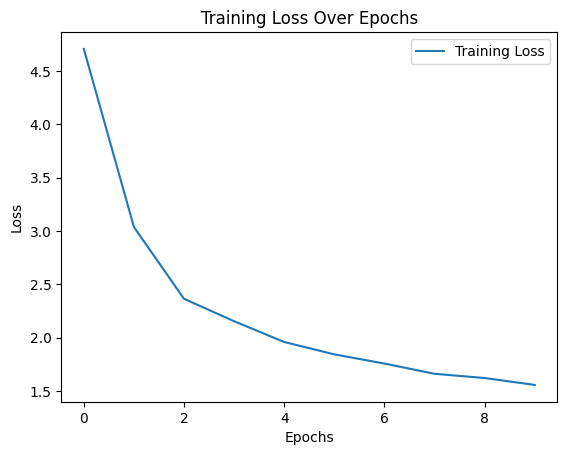

In [ ]:
#Plotting loss

plt.plot(epoch_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
test_input_texts = [str(entry) for entry in T5_data_linearb_names_test['linear_b_transliterated_sep']]
test_inputs = tokenizer(test_input_texts, return_tensors='pt', padding=True, truncation=True)

# Evaluate
model.eval()
with torch.no_grad():
    test_inputs = {k: v for k, v in test_inputs.items()}
    test_summary_ids = model.generate(test_inputs['input_ids'], num_beams=4, no_repeat_ngram_size=2, max_length=50)


In [ ]:
#Test
print(similarity_scores("aetito","aethistos"))

0.3333333333333333


In [ ]:
test_predictions = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in test_summary_ids]

comparison_df=[]
#for prediction in test_predictions:
#    print(prediction)
assert(len(test_inputs["input_ids"])==len(test_predictions))

#get linear b transliteration in the original non-names dataset, and in the input test dataset
for i in range(len(test_predictions)):

    cur_prediction_greek=test_predictions[i]
    #print(cur_prediction_greek)
    cur_split_linb_transliteration=T5_data_linearb_names_test["linear_b_transliterated_sep"].iloc[i]

    #get the subset of the original non-names dataset which has the same linear_b transliteration
    data_linearb_subset=data_linearb_split[data_linearb_split["linear_b_transliterated_sep"]==cur_split_linb_transliteration]
    if len(data_linearb_subset)==0:
        print(i)

    #build up prediction vs. actual, and append the maximum score for the current input
    scores=[]
    indices=[]
    for j in range(len(data_linearb_subset)):
        #print(cur_prediction_greek,"|",data_linearb_subset["greek_transliterate"].iloc[j])
        comparison_df.append([cur_split_linb_transliteration,cur_prediction_greek,\
                              data_linearb_subset["greek_transliterate"].iloc[j]])
        if i<5:print(cur_prediction_greek,data_linearb_subset["greek_transliterate"].iloc[j])
        scores.append(similarity_scores(cur_prediction_greek,data_linearb_subset["greek_transliterate"].iloc[j]))
    best_score_for_subset=min(scores)
    for lst in comparison_df:
        if lst[0]!=cur_split_linb_transliteration:continue
        lst.append(best_score_for_subset)


comparison_df=pd.DataFrame(comparison_df,columns=["Original Linear B","Prediction","Actual","Best Levenshtein Similarity Score"])

aetitos aethistos
aetitos ethizo
adete andetir
adete andetires
adiria andriantei
adiria andriafi
adiria andrios
adiria aner
ajamna aiasmena
ajamna aiasmenos
akaros akaranos


In [ ]:
#Printing comparison table with Levenshtein scores

print(comparison_df.head(10))
print("\nMean Best Levenshtein Similarity Score:", comparison_df["Best Levenshtein Similarity Score"].mean())

               Original Linear B Prediction      Actual  \
0          a<SEP>e<SEP>ti<SEP>to    aetitos   aethistos   
1          a<SEP>e<SEP>ti<SEP>to    aetitos      ethizo   
2                a<SEP>de<SEP>te      adete     andetir   
3                a<SEP>de<SEP>te      adete   andetires   
4  a<SEP>di<SEP>ri<SEP>ja<SEP>pi     adiria  andriantei   
5  a<SEP>di<SEP>ri<SEP>ja<SEP>pi     adiria    andriafi   
6  a<SEP>di<SEP>ri<SEP>ja<SEP>pi     adiria     andrios   
7  a<SEP>di<SEP>ri<SEP>ja<SEP>pi     adiria        aner   
8         a<SEP>ja<SEP>me<SEP>na     ajamna    aiasmena   
9         a<SEP>ja<SEP>me<SEP>na     ajamna   aiasmenos   

   Best Levenshtein Similarity Score  
0                           0.222222  
1                           0.222222  
2                           0.428571  
3                           0.428571  
4                           0.500000  
5                           0.500000  
6                           0.500000  
7                           0.500000  

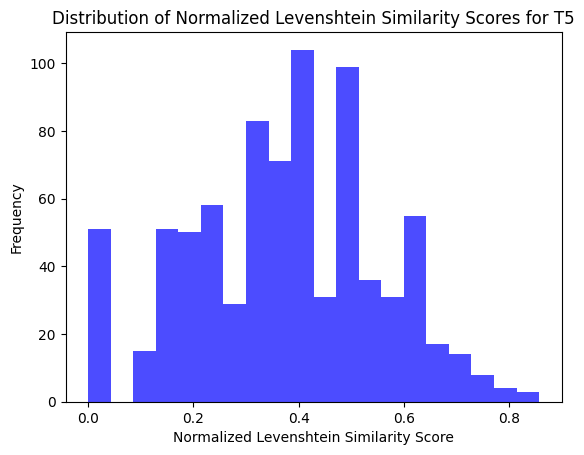

In [ ]:
# Extract the 'Best Levenshtein Similarity Score' column values
lev_similarity_scores = comparison_df['Best Levenshtein Similarity Score'].values

# Plot histogram of normalized Levenshtein similarity scores
plt.hist(lev_similarity_scores, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Normalized Levenshtein Similarity Scores for T5')
plt.xlabel('Normalized Levenshtein Similarity Score')
plt.ylabel('Frequency')
plt.show()


### 2. Modified T5 with Custom Loss

- Custom loss based on MIT paper. Regularizes terms based on edit distance.

In [ ]:
def custom_loss(outputs, labels, tokenizer, alpha=0.1):

    # Standard loss calculation
    standard_loss = outputs.loss

    # Regularization term based on edit distance
    edit_distance_loss = 0.0
    predictions = torch.argmax(outputs.logits, dim=-1)

    for pred, label in zip(predictions, labels):

        #ensure token IDs are within range
        pred = pred[pred < tokenizer.vocab_size]
        label = label[label < tokenizer.vocab_size]

        pred_str = tokenizer.decode(pred.tolist(), skip_special_tokens=True)
        label_str = tokenizer.decode(label.tolist(), skip_special_tokens=True)
        edit_distance_loss += levenshtein.distance(pred_str, label_str)

    edit_distance_loss = alpha * edit_distance_loss / len(predictions)

    # Combine the standard loss with the regularization term
    total_loss = standard_loss + edit_distance_loss
    return total_loss

In [ ]:
#T5 Model Modified

# Load tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')


# Prepare dataset and dataloader
use_masked_data = 'yes'  #or 'no'
train_dataset = LinearBToGreekDataset(T5_data_linearb_names_train, tokenizer, masked=use_masked_data)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=train_dataset.collate_fn)


optimizer = AdamW(model.parameters(), lr=T5_lr)

epoch_loss = []

# Training loop
model.train()
for epoch in range(T5_epochs):
    total_loss = 0

    for batch in train_loader:
        input_ids, labels = batch

        # Forward pass
        outputs = model(input_ids=input_ids, labels=labels)
        loss = custom_loss(outputs, labels, T5_tokenizer)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_loss.append(avg_loss)

    print(f"Epoch {epoch}, Loss: {avg_loss}")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0, Loss: 5.584655146849783
Epoch 1, Loss: 3.881661107665614
Epoch 2, Loss: 3.123762268769114
Epoch 3, Loss: 2.826752022693032
Epoch 4, Loss: 2.6675202470076713
Epoch 5, Loss: 2.603766366055137
Epoch 6, Loss: 2.4831069770612215
Epoch 7, Loss: 2.410714240450608
Epoch 8, Loss: 2.3374549903367696
Epoch 9, Loss: 2.2586230290563485


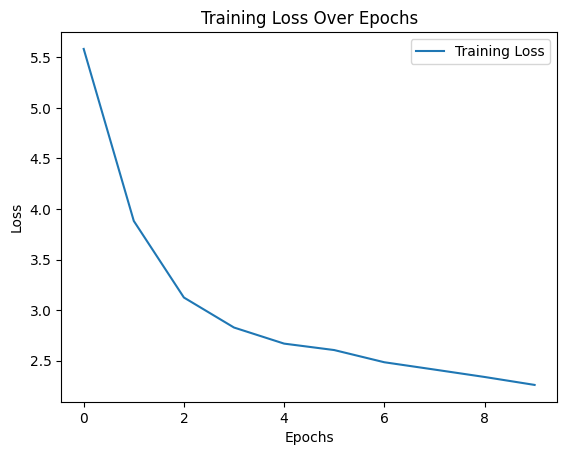

In [ ]:
#Plotting loss

plt.plot(epoch_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
test_input_texts = [str(entry) for entry in T5_data_linearb_names_test['linear_b_transliterated_sep']]
test_inputs = tokenizer(test_input_texts, return_tensors='pt', padding=True, truncation=True)

# Evaluate
model.eval()
with torch.no_grad():
    test_inputs = {k: v for k, v in test_inputs.items()}
    test_summary_ids = model.generate(test_inputs['input_ids'], num_beams=4, no_repeat_ngram_size=2, max_length=50)


In [ ]:
#Test
print(similarity_scores("aetito","aethistos"))

0.3333333333333333


In [ ]:
test_predictions = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in test_summary_ids]

comparison_df=[]
#for prediction in test_predictions:
#    print(prediction)
assert(len(test_inputs["input_ids"])==len(test_predictions))

#get linear b transliteration in the original non-names dataset, and in the input test dataset
for i in range(len(test_predictions)):

    cur_prediction_greek=test_predictions[i]
    #print(cur_prediction_greek)
    cur_split_linb_transliteration=T5_data_linearb_names_test["linear_b_transliterated_sep"].iloc[i]

    #get the subset of the original non-names dataset which has the same linear_b transliteration
    data_linearb_subset=data_linearb_split[data_linearb_split["linear_b_transliterated_sep"]==cur_split_linb_transliteration]
    if len(data_linearb_subset)==0:
        print(i)

    #build up prediction vs. actual, and append the maximum score for the current input
    scores=[]
    indices=[]
    for j in range(len(data_linearb_subset)):
        #print(cur_prediction_greek,"|",data_linearb_subset["greek_transliterate"].iloc[j])
        comparison_df.append([cur_split_linb_transliteration,cur_prediction_greek,\
                              data_linearb_subset["greek_transliterate"].iloc[j]])
        if i<5:print(cur_prediction_greek,data_linearb_subset["greek_transliterate"].iloc[j])
        scores.append(similarity_scores(cur_prediction_greek,data_linearb_subset["greek_transliterate"].iloc[j]))
    best_score_for_subset=min(scores)
    for lst in comparison_df:
        if lst[0]!=cur_split_linb_transliteration:continue
        lst.append(best_score_for_subset)


comparison_df=pd.DataFrame(comparison_df,columns=["Original Linear B","Prediction","Actual","Best Levenshtein Similarity Score"])

aetios aethistos
aetios ethizo
adefeios andetir
adefeios andetires
adios andriantei
adios andriafi
adios andrios
adios aner
ajamna aiasmena
ajamna aiasmenos
afonos akaranos


In [ ]:
#Printing comparison table with Levenshtein scores

print(comparison_df.head(10))
print("\nMean Best Levenshtein Similarity Score:", comparison_df["Best Levenshtein Similarity Score"].mean())

               Original Linear B Prediction      Actual  \
0          a<SEP>e<SEP>ti<SEP>to     aetios   aethistos   
1          a<SEP>e<SEP>ti<SEP>to     aetios      ethizo   
2                a<SEP>de<SEP>te   adefeios     andetir   
3                a<SEP>de<SEP>te   adefeios   andetires   
4  a<SEP>di<SEP>ri<SEP>ja<SEP>pi      adios  andriantei   
5  a<SEP>di<SEP>ri<SEP>ja<SEP>pi      adios    andriafi   
6  a<SEP>di<SEP>ri<SEP>ja<SEP>pi      adios     andrios   
7  a<SEP>di<SEP>ri<SEP>ja<SEP>pi      adios        aner   
8         a<SEP>ja<SEP>me<SEP>na     ajamna    aiasmena   
9         a<SEP>ja<SEP>me<SEP>na     ajamna   aiasmenos   

   Best Levenshtein Similarity Score  
0                           0.333333  
1                           0.333333  
2                           0.555556  
3                           0.555556  
4                           0.285714  
5                           0.285714  
6                           0.285714  
7                           0.285714  

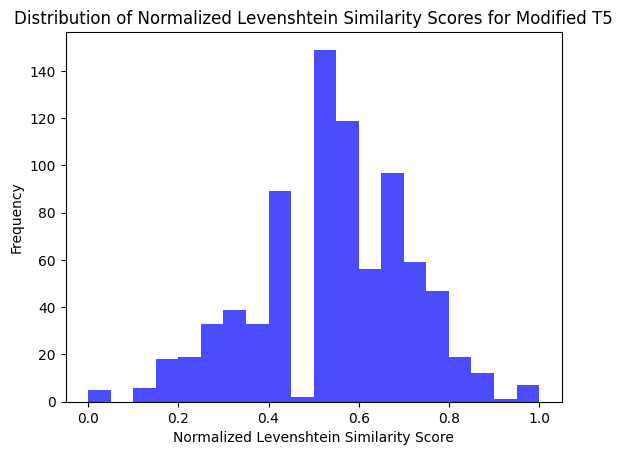

In [ ]:
# Extract the 'Best Levenshtein Similarity Score' column values
lev_similarity_scores = comparison_df['Best Levenshtein Similarity Score'].values

# Plot histogram of normalized Levenshtein similarity scores
plt.hist(lev_similarity_scores, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Normalized Levenshtein Similarity Scores for Modified T5')
plt.xlabel('Normalized Levenshtein Similarity Score')
plt.ylabel('Frequency')
plt.show()


## EVALUATION

- Model performance evaluation

### T5 Evaluation

#### T5 Evaluation Function

In [ ]:
def T5_train_and_evaluate(T5_lr, T5_epochs, alpha=0.5, custom_loss_selected='no', use_masked_data='no', num_beams_input=4, no_repeat_ngram_size_input=2):

    #Initialize
    tokenizer = T5Tokenizer.from_pretrained('t5-small')
    model = T5ForConditionalGeneration.from_pretrained('t5-small')

    # Prepare dataset and dataloader
    train_dataset = LinearBToGreekDataset(T5_data_linearb_names_train, tokenizer, masked=use_masked_data)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=train_dataset.collate_fn)

    optimizer = AdamW(model.parameters(), lr=T5_lr)

    # Training loop
    model.train()
    epoch_loss = []
    for epoch in range(T5_epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids, labels = batch
            outputs = model(input_ids=input_ids, labels=labels)

            if custom_loss_selected == 'yes':
              loss = custom_loss(outputs, labels, tokenizer, alpha)
            else:
              loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        epoch_loss.append(avg_loss)

    #plot loss
    plt.plot(epoch_loss, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

    # Evaluation
    model.eval()
    test_input_texts = [str(entry) for entry in T5_data_linearb_names_test['linear_b_transliterated_sep']]
    test_inputs = tokenizer(test_input_texts, return_tensors='pt', padding=True, truncation=True)

    with torch.no_grad():
        test_inputs = {k: v for k, v in test_inputs.items()}
        test_summary_ids = model.generate(test_inputs['input_ids'], num_beams=num_beams_input, no_repeat_ngram_size=no_repeat_ngram_size_input, max_length=50)

    test_predictions = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in test_summary_ids]

    #COmparison & similarity score for model
    comparison_df=[]
    assert(len(test_inputs["input_ids"])==len(test_predictions))
    for i in range(len(test_predictions)):

        cur_prediction_greek=test_predictions[i]
        #print(cur_prediction_greek)
        cur_split_linb_transliteration=T5_data_linearb_names_test["linear_b_transliterated_sep"].iloc[i]

        #get the subset of the original non-names dataset which has the same linear_b transliteration
        data_linearb_subset=data_linearb_split[data_linearb_split["linear_b_transliterated_sep"]==cur_split_linb_transliteration]
        # if len(data_linearb_subset)==0:
            # print(i)

        #build up prediction vs. actual, and append the maximum score for the current input
        scores=[]
        indices=[]
        for j in range(len(data_linearb_subset)):
            #print(cur_prediction_greek,"|",data_linearb_subset["greek_transliterate"].iloc[j])
            comparison_df.append([cur_split_linb_transliteration,cur_prediction_greek,\
                                data_linearb_subset["greek_transliterate"].iloc[j]])
            # if i<5:print(cur_prediction_greek,data_linearb_subset["greek_transliterate"].iloc[j])
            scores.append(similarity_scores(cur_prediction_greek,data_linearb_subset["greek_transliterate"].iloc[j]))
        best_score_for_subset=min(scores)
        for lst in comparison_df:
            if lst[0]!=cur_split_linb_transliteration:continue
            lst.append(best_score_for_subset)


    comparison_df=pd.DataFrame(comparison_df,columns=["Original Linear B","Prediction","Actual","Best Levenshtein Similarity Score"])

    #Plotting results
    lev_similarity_scores = comparison_df['Best Levenshtein Similarity Score'].values

    # Plot histogram of normalized Levenshtein similarity scores
    plt.hist(lev_similarity_scores, bins=20, color='blue', alpha=0.7)
    plt.title('Distribution of Normalized Levenshtein Similarity Scores for T5')
    plt.xlabel('Normalized Levenshtein Similarity Score')
    plt.ylabel('Frequency')
    plt.show()

    # return mean best Levenshtein similarity score
    return comparison_df["Best Levenshtein Similarity Score"].mean()

**Scenario 4: With Masking**

Testing Case with: learning rate 0.0001, epochs 10, alpha 0.5, num_beams 4, no_repeat_ngram_size 2


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


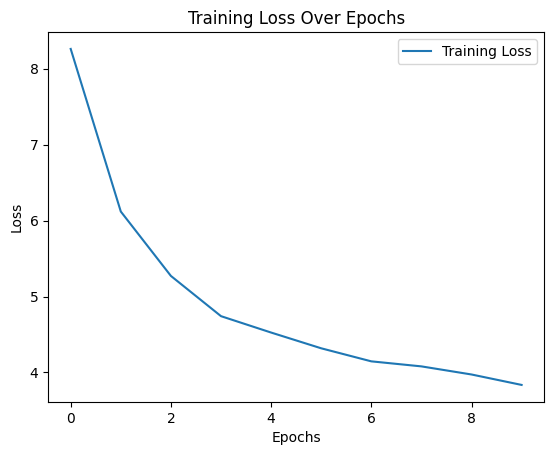

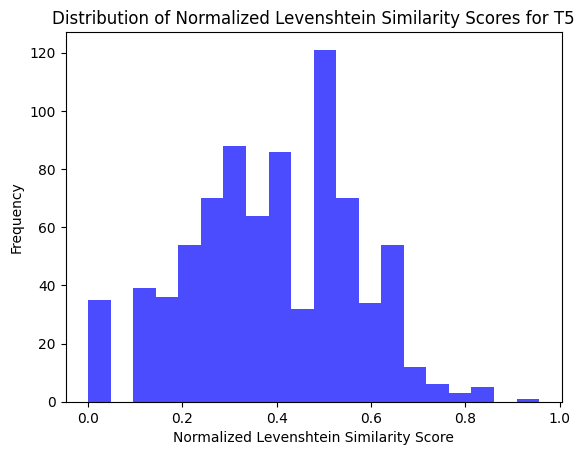

Testing Case with: learning rate 0.0001, epochs 10, alpha 0.5, num_beams 4, no_repeat_ngram_size 4


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


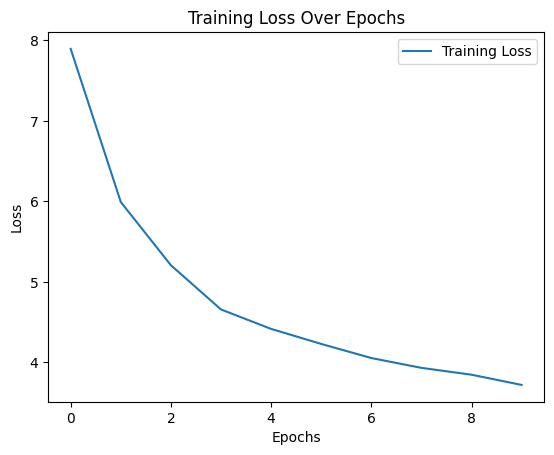

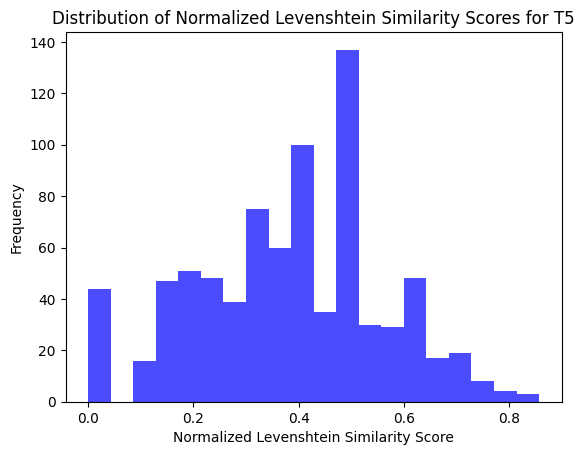

Testing Case with: learning rate 0.0001, epochs 10, alpha 0.5, num_beams 8, no_repeat_ngram_size 2


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


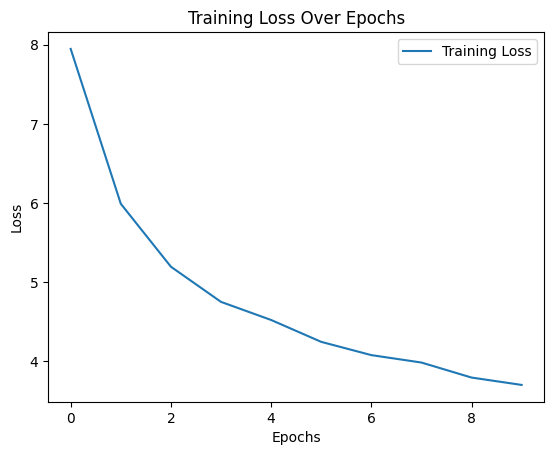

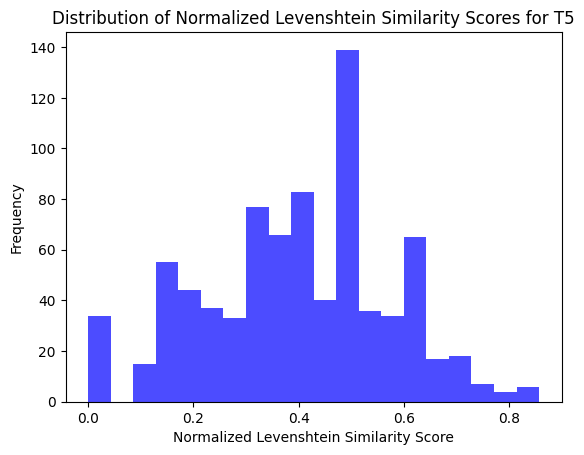

Testing Case with: learning rate 0.0001, epochs 10, alpha 0.5, num_beams 8, no_repeat_ngram_size 4


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


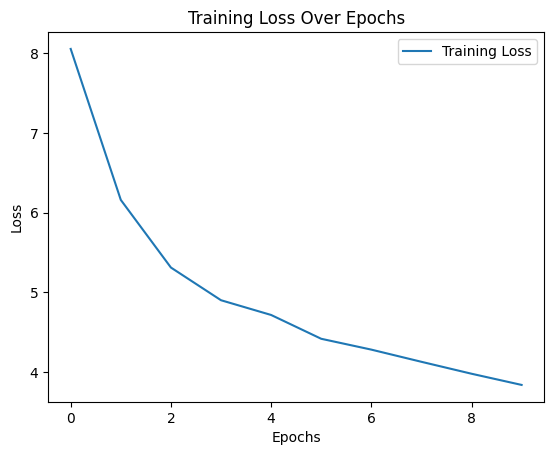

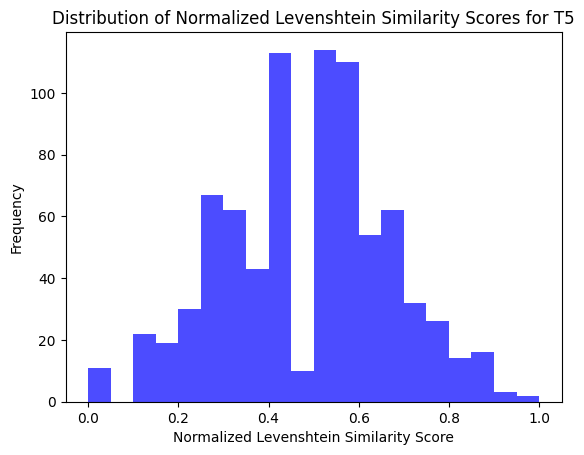

Testing Case with: learning rate 0.0001, epochs 10, alpha 0.7, num_beams 4, no_repeat_ngram_size 2


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


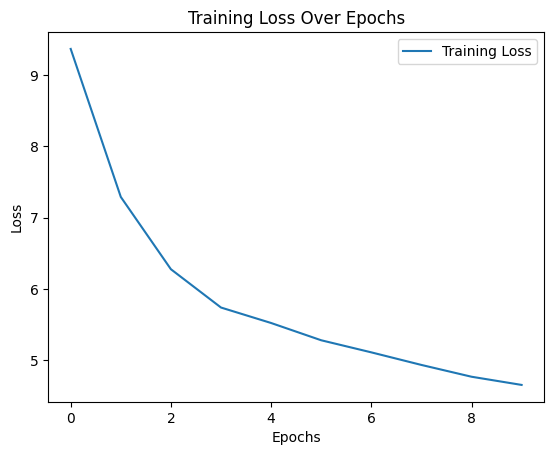

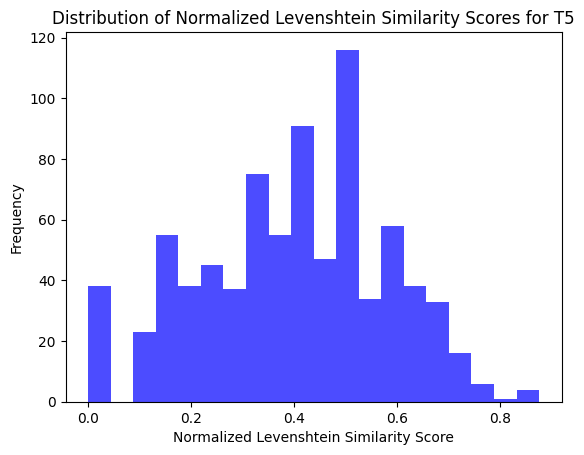

Testing Case with: learning rate 0.0001, epochs 10, alpha 0.7, num_beams 4, no_repeat_ngram_size 4


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


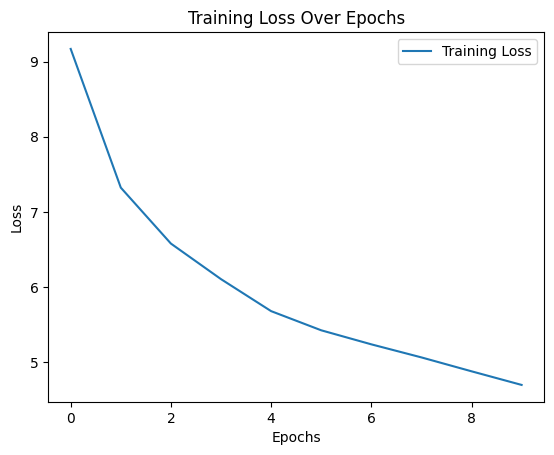

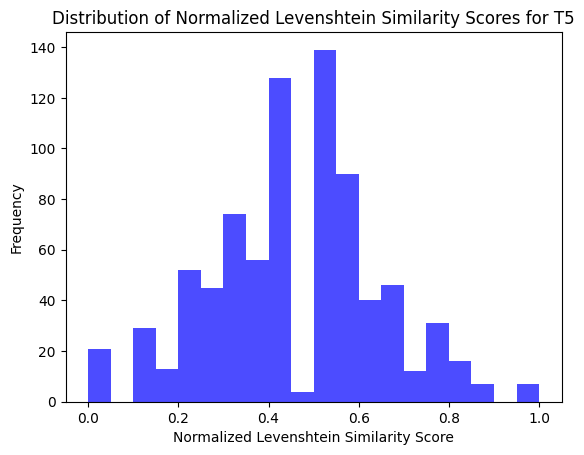

Testing Case with: learning rate 0.0001, epochs 10, alpha 0.7, num_beams 8, no_repeat_ngram_size 2


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


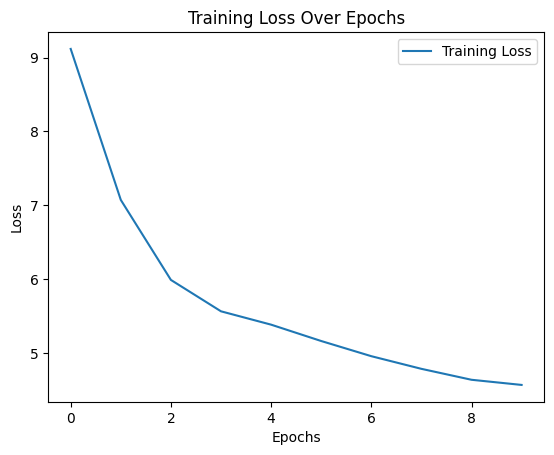

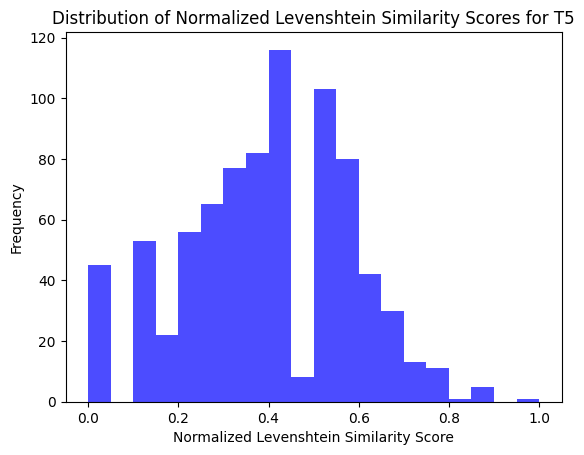

Testing Case with: learning rate 0.0001, epochs 10, alpha 0.7, num_beams 8, no_repeat_ngram_size 4


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


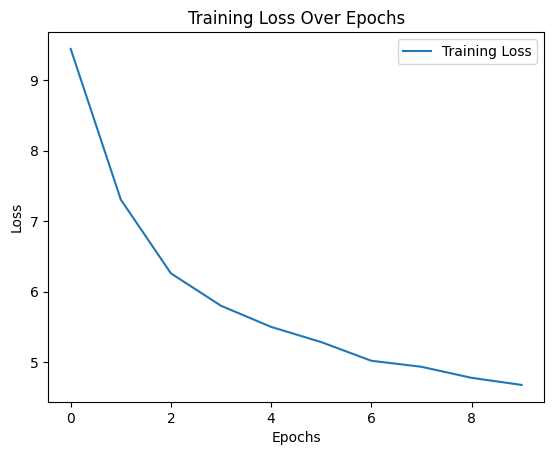

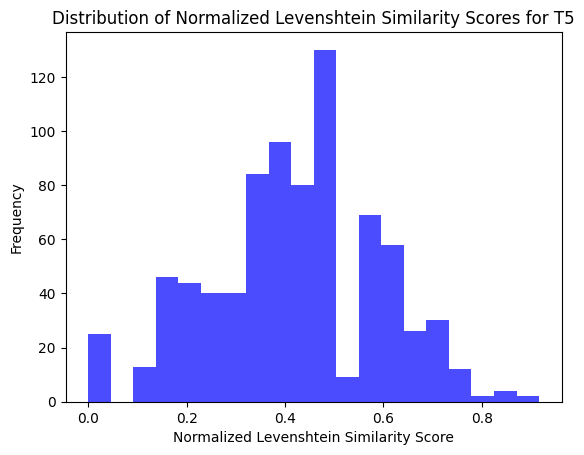

Testing Case with: learning rate 0.0001, epochs 20, alpha 0.5, num_beams 4, no_repeat_ngram_size 2


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


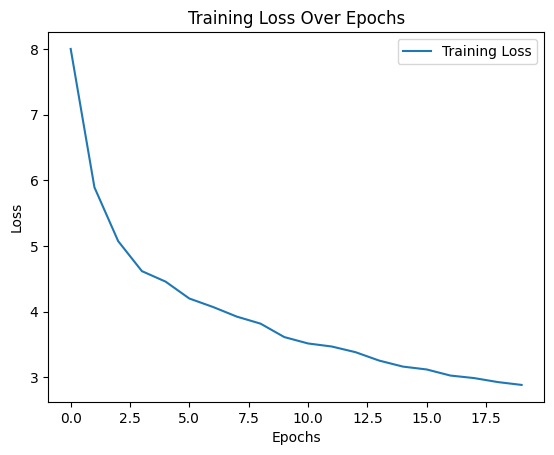

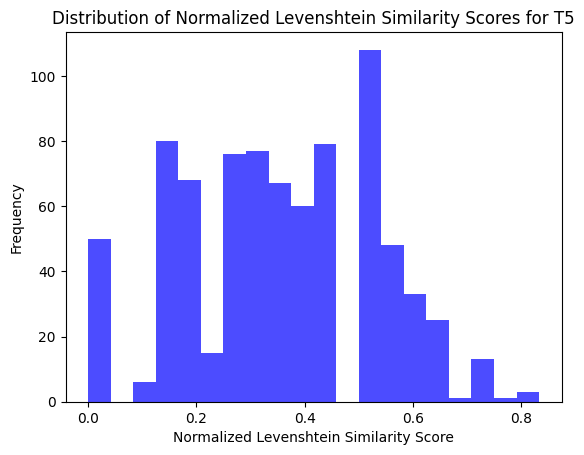

Testing Case with: learning rate 0.0001, epochs 20, alpha 0.5, num_beams 4, no_repeat_ngram_size 4


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


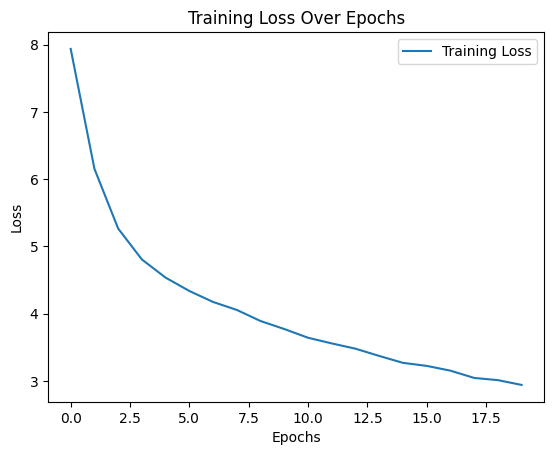

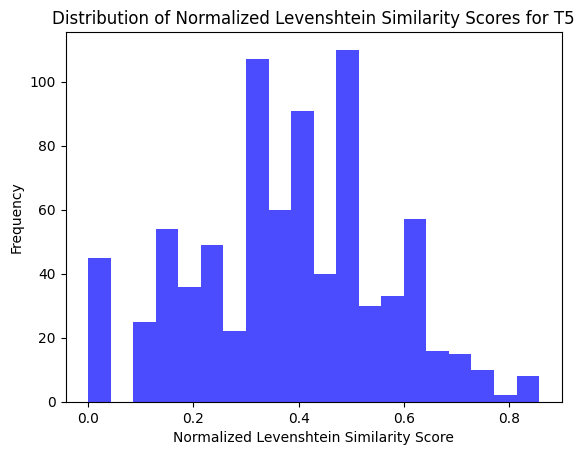

Testing Case with: learning rate 0.0001, epochs 20, alpha 0.5, num_beams 8, no_repeat_ngram_size 2


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


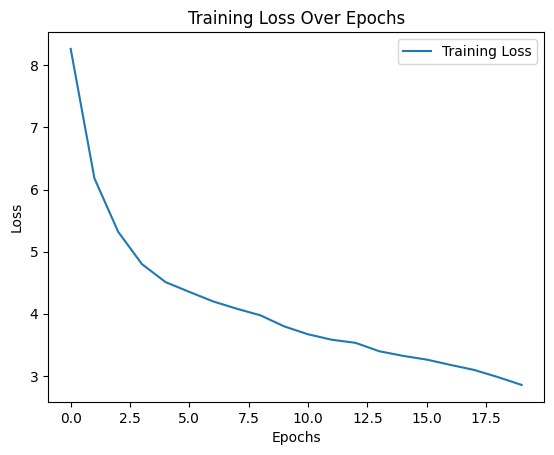

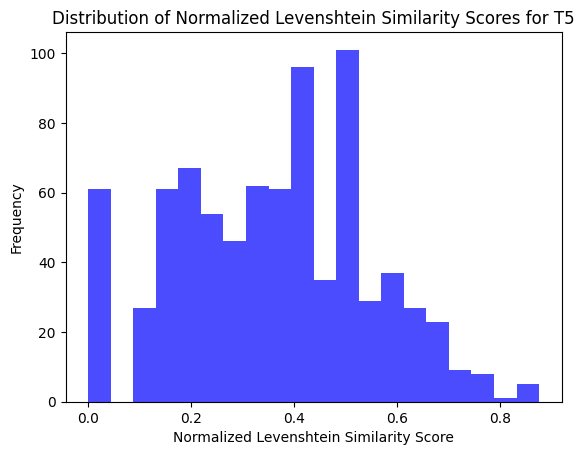

Testing Case with: learning rate 0.0001, epochs 20, alpha 0.5, num_beams 8, no_repeat_ngram_size 4


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


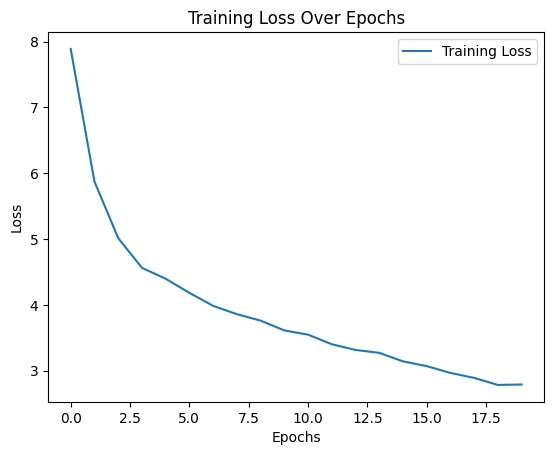

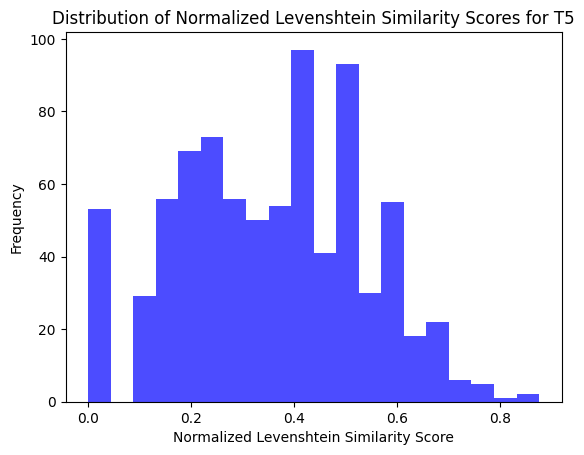

Testing Case with: learning rate 0.0001, epochs 20, alpha 0.7, num_beams 4, no_repeat_ngram_size 2


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


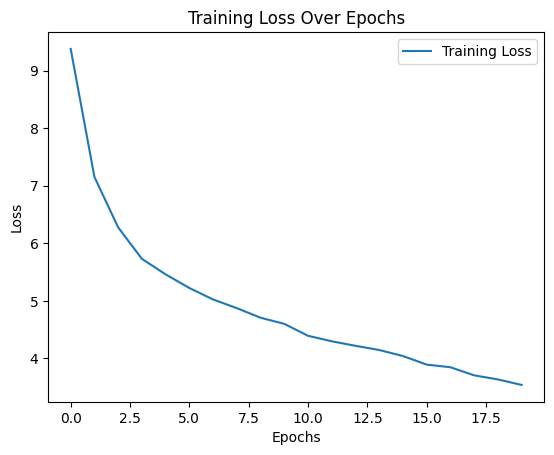

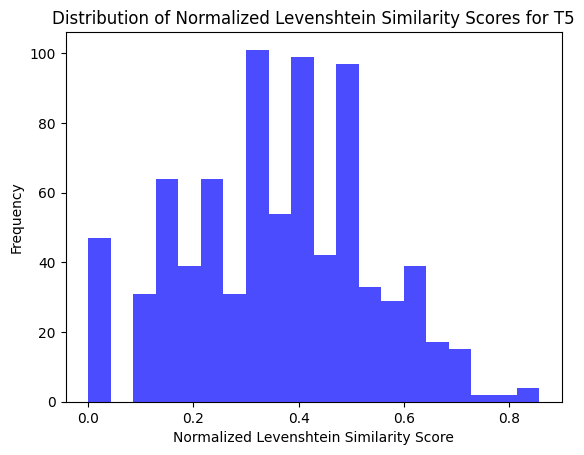

Testing Case with: learning rate 0.0001, epochs 20, alpha 0.7, num_beams 4, no_repeat_ngram_size 4


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


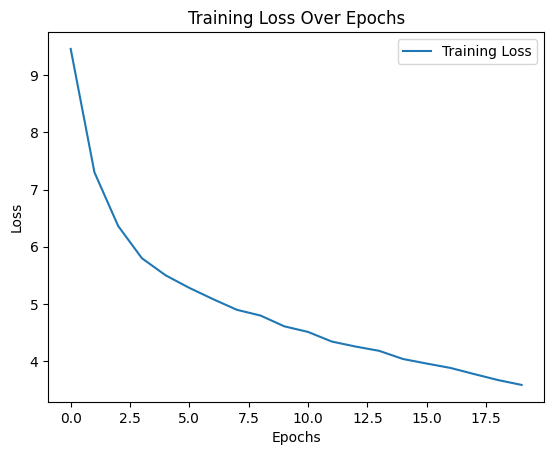

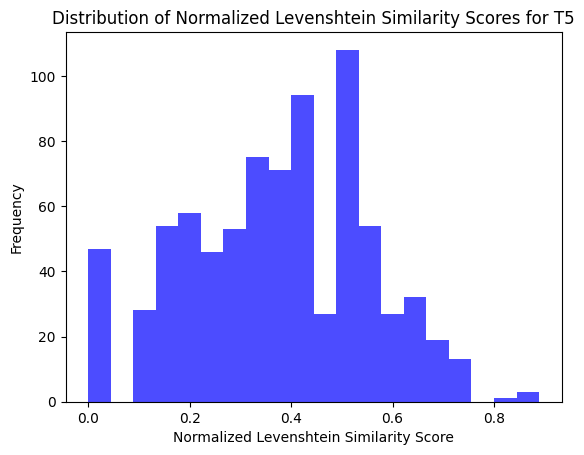

Testing Case with: learning rate 0.0001, epochs 20, alpha 0.7, num_beams 8, no_repeat_ngram_size 2


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


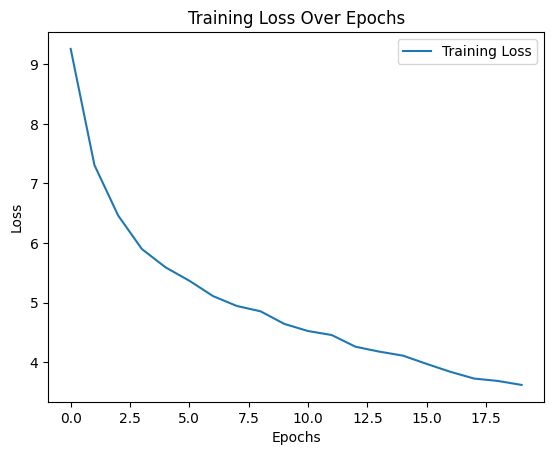

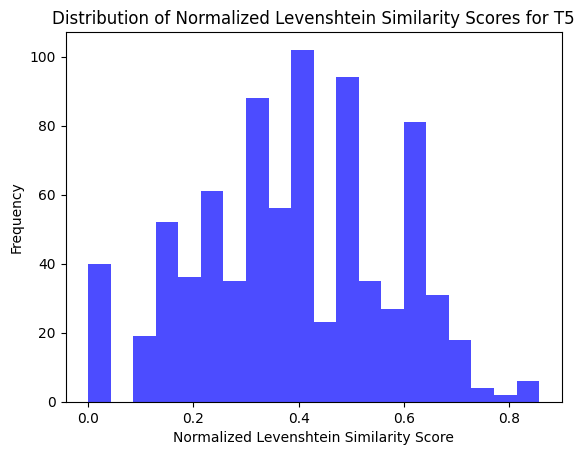

Testing Case with: learning rate 0.0001, epochs 20, alpha 0.7, num_beams 8, no_repeat_ngram_size 4


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


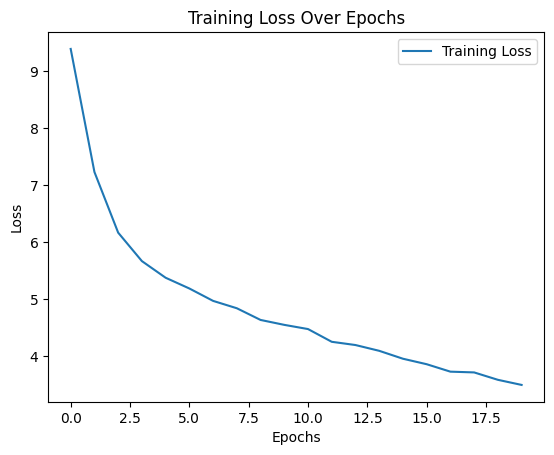

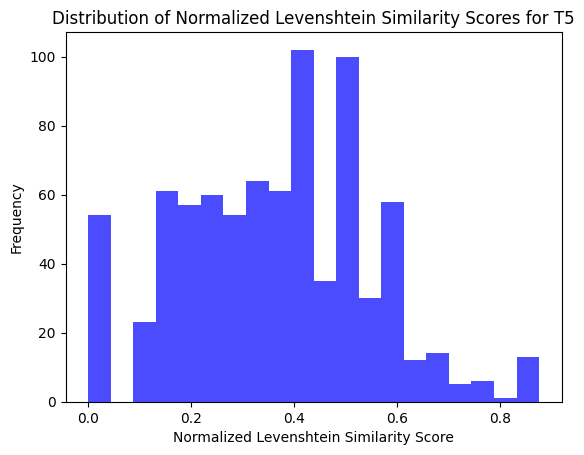

Testing Case with: learning rate 0.0005, epochs 10, alpha 0.5, num_beams 4, no_repeat_ngram_size 2


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


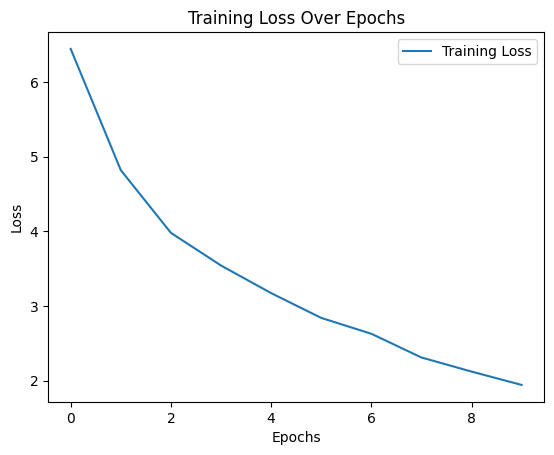

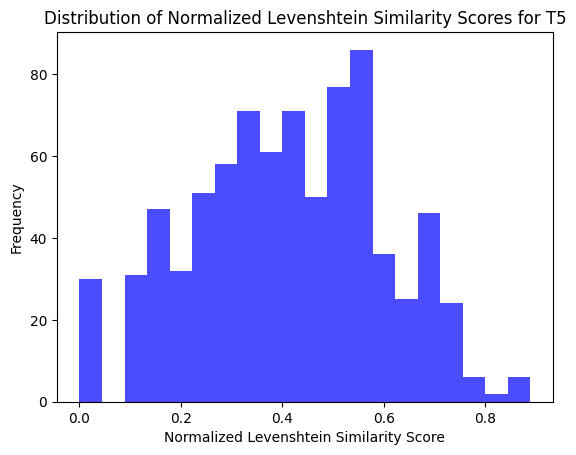

Testing Case with: learning rate 0.0005, epochs 10, alpha 0.5, num_beams 4, no_repeat_ngram_size 4


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


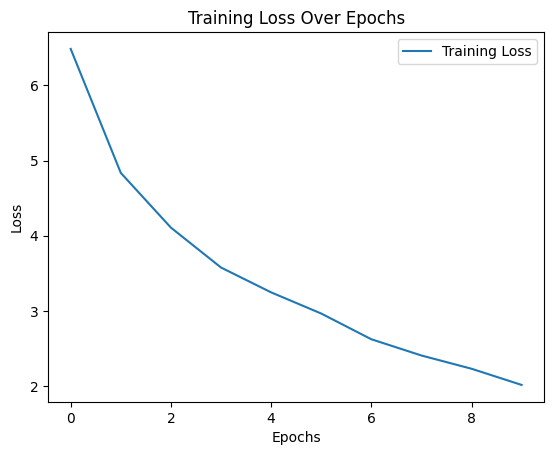

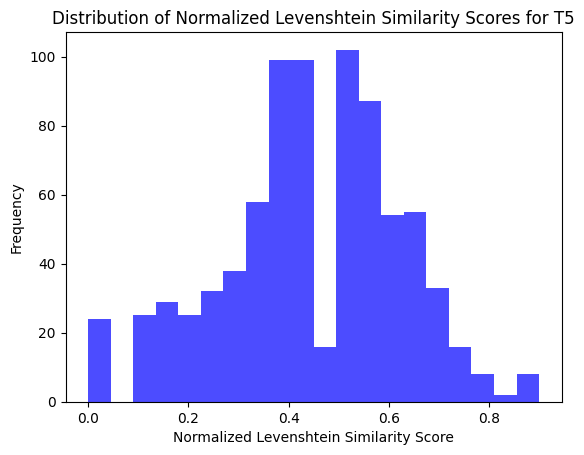

Testing Case with: learning rate 0.0005, epochs 10, alpha 0.5, num_beams 8, no_repeat_ngram_size 2


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


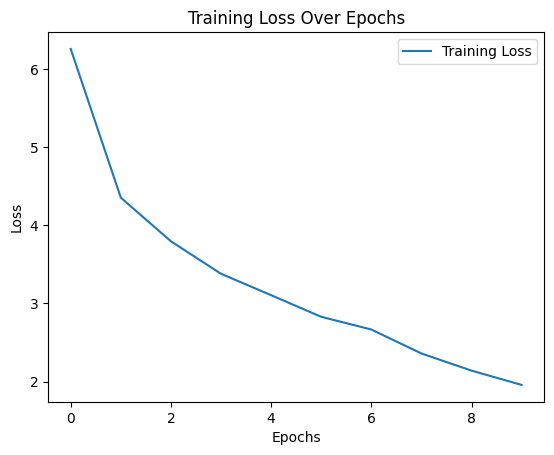

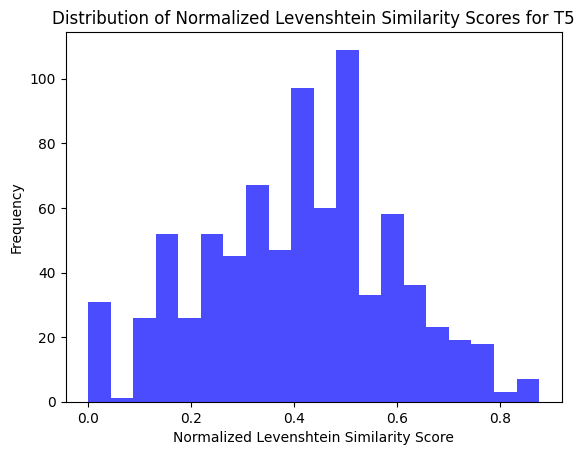

Testing Case with: learning rate 0.0005, epochs 10, alpha 0.5, num_beams 8, no_repeat_ngram_size 4


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


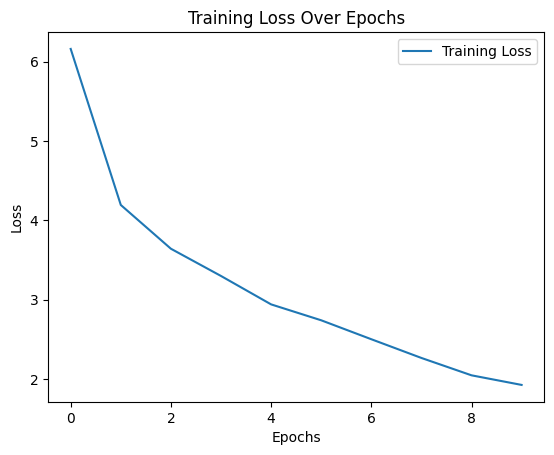

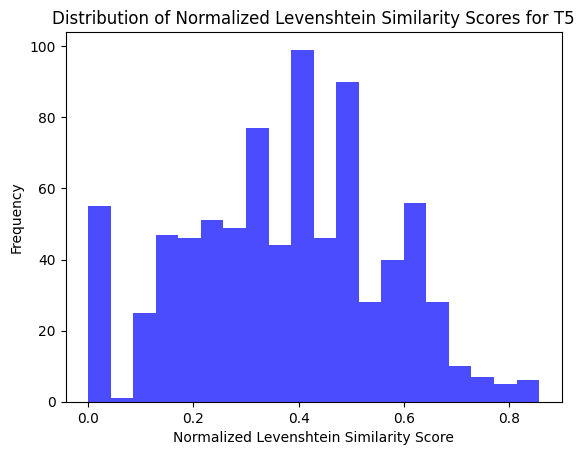

Testing Case with: learning rate 0.0005, epochs 10, alpha 0.7, num_beams 4, no_repeat_ngram_size 2


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


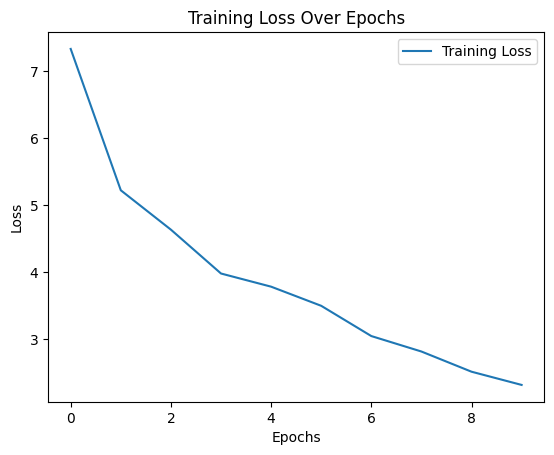

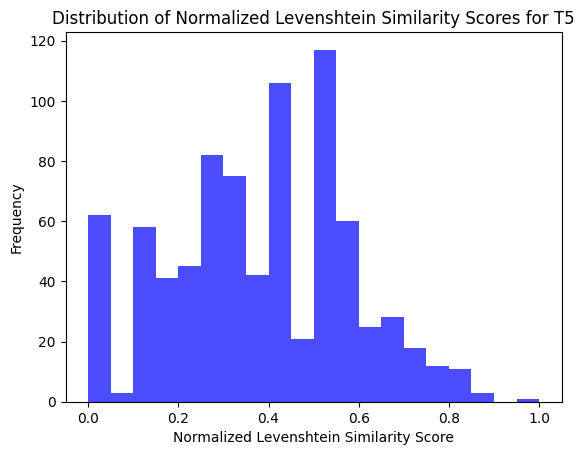

Testing Case with: learning rate 0.0005, epochs 10, alpha 0.7, num_beams 4, no_repeat_ngram_size 4


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


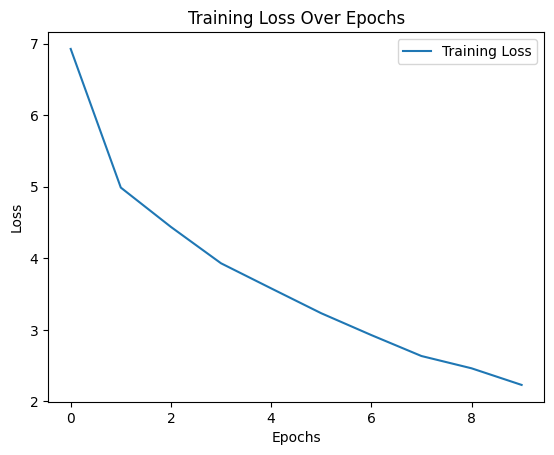

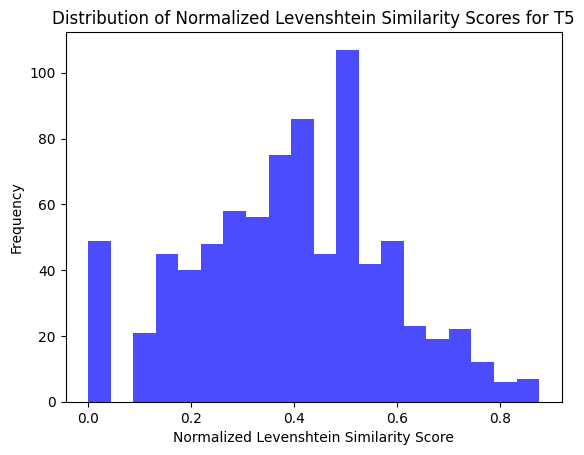

Testing Case with: learning rate 0.0005, epochs 10, alpha 0.7, num_beams 8, no_repeat_ngram_size 2


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


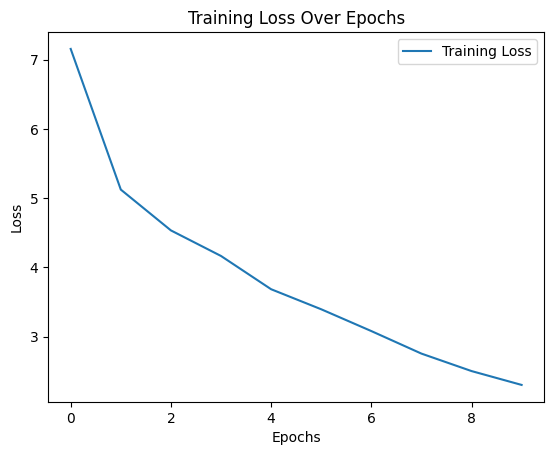

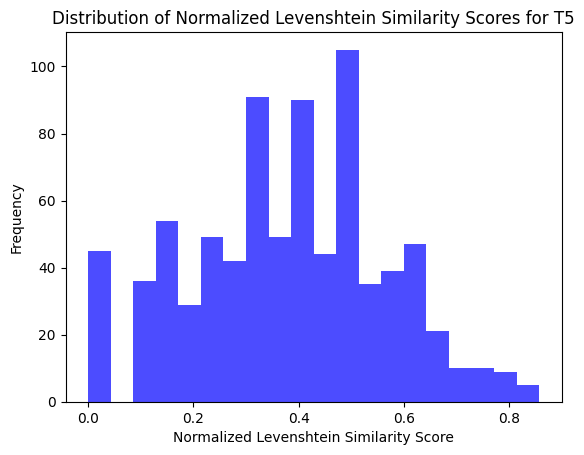

Testing Case with: learning rate 0.0005, epochs 10, alpha 0.7, num_beams 8, no_repeat_ngram_size 4


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


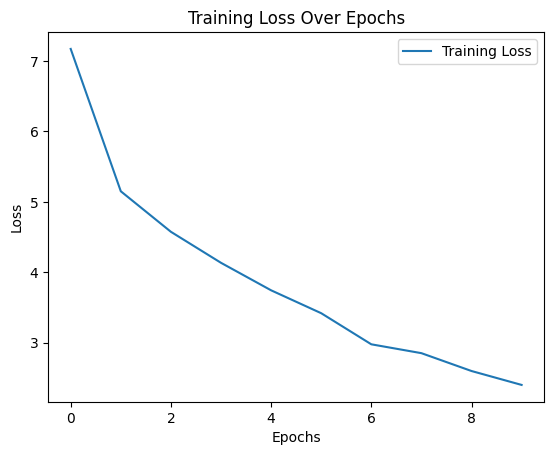

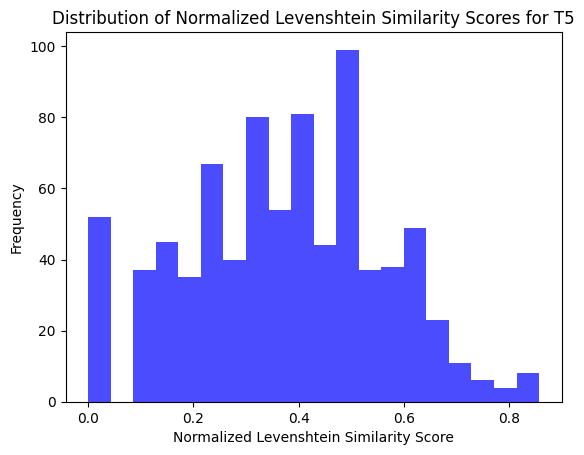

Testing Case with: learning rate 0.0005, epochs 20, alpha 0.5, num_beams 4, no_repeat_ngram_size 2


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


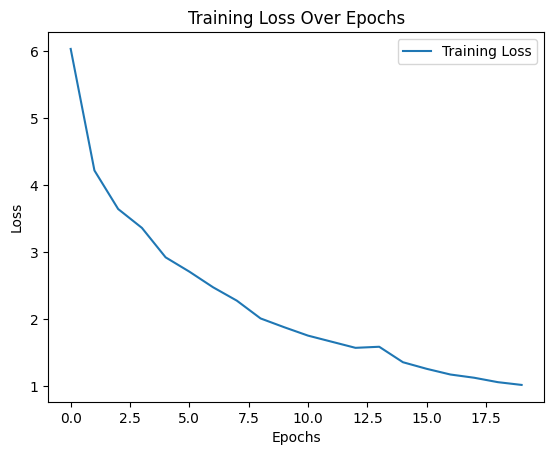

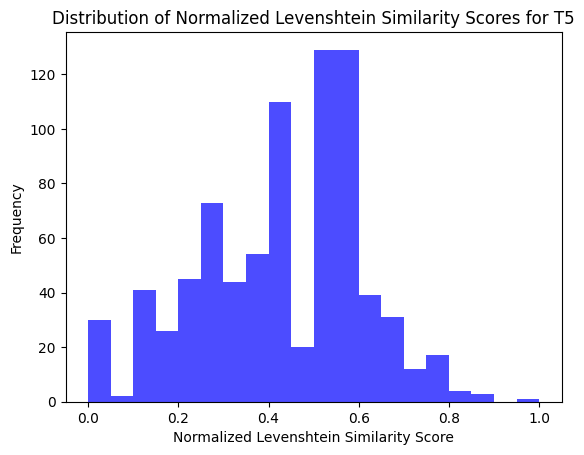

Testing Case with: learning rate 0.0005, epochs 20, alpha 0.5, num_beams 4, no_repeat_ngram_size 4


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


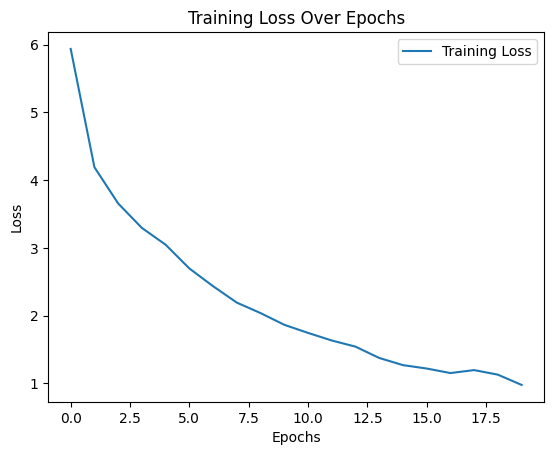

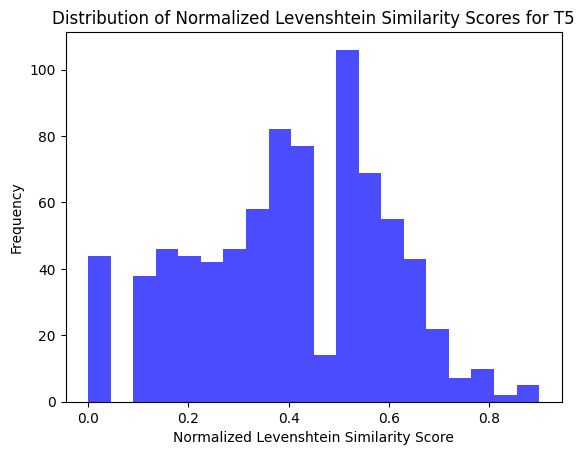

Testing Case with: learning rate 0.0005, epochs 20, alpha 0.5, num_beams 8, no_repeat_ngram_size 2


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


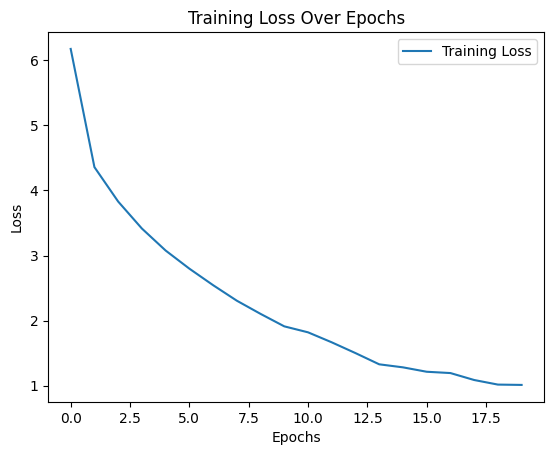

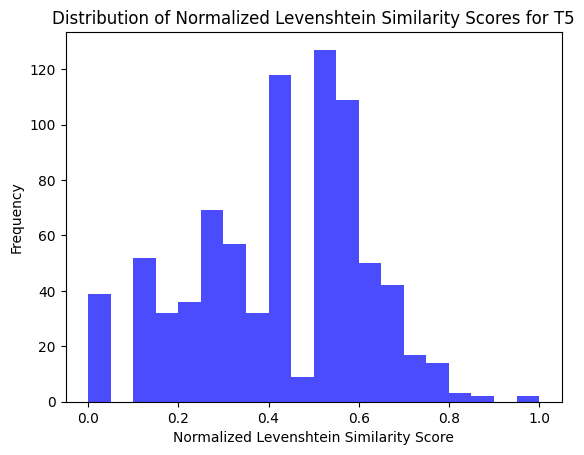

Testing Case with: learning rate 0.0005, epochs 20, alpha 0.5, num_beams 8, no_repeat_ngram_size 4


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


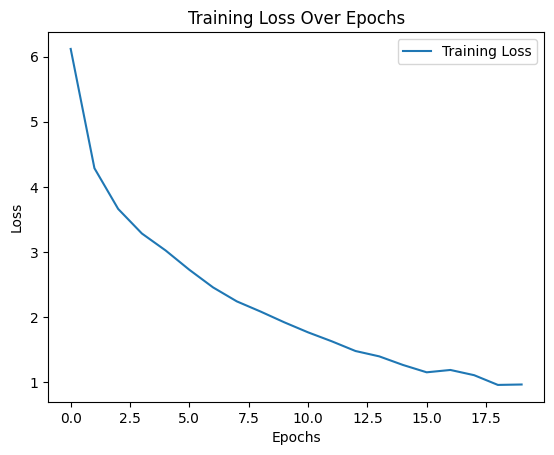

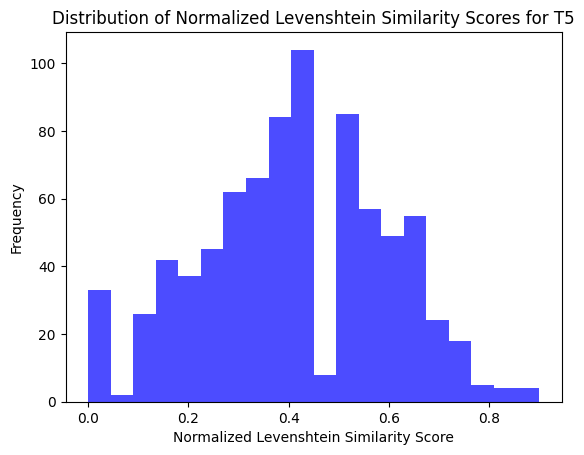

Testing Case with: learning rate 0.0005, epochs 20, alpha 0.7, num_beams 4, no_repeat_ngram_size 2


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


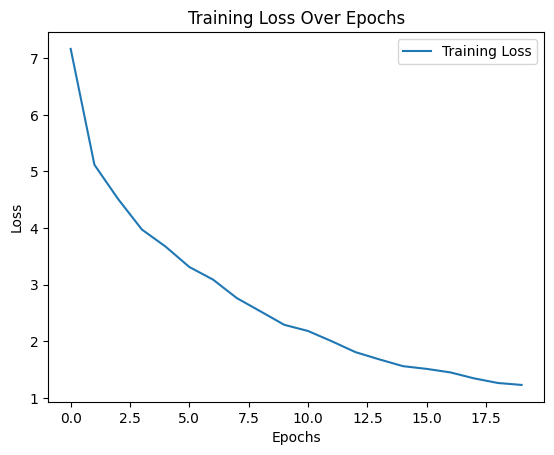

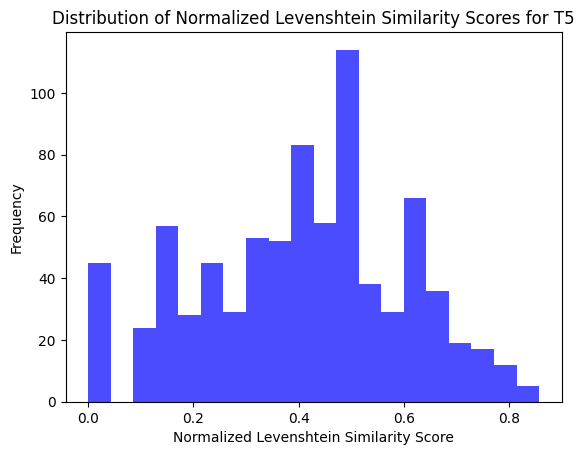

Testing Case with: learning rate 0.0005, epochs 20, alpha 0.7, num_beams 4, no_repeat_ngram_size 4


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


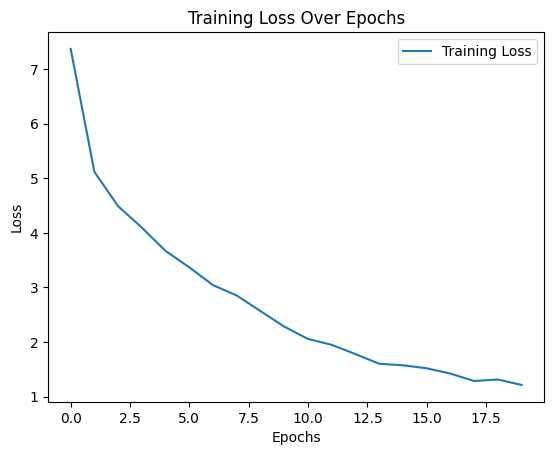

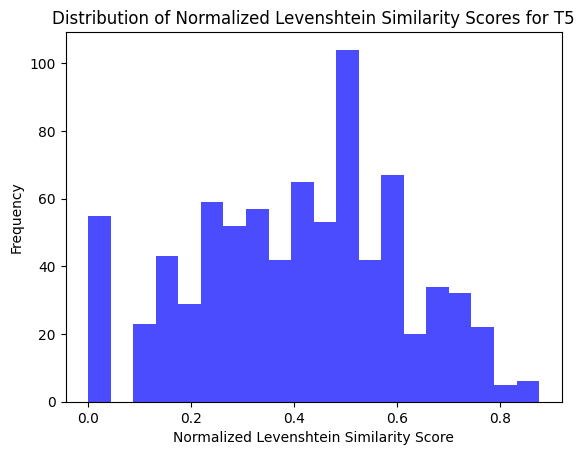

Testing Case with: learning rate 0.0005, epochs 20, alpha 0.7, num_beams 8, no_repeat_ngram_size 2


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


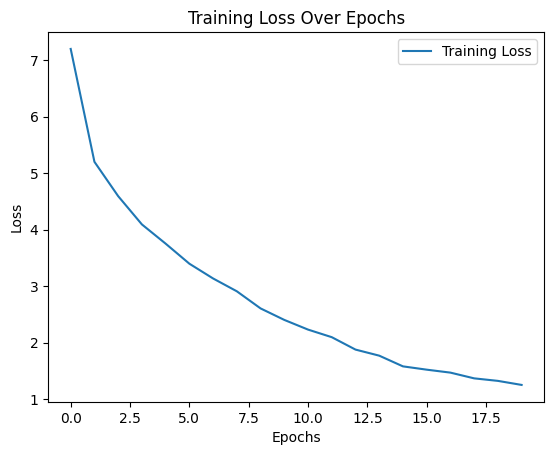

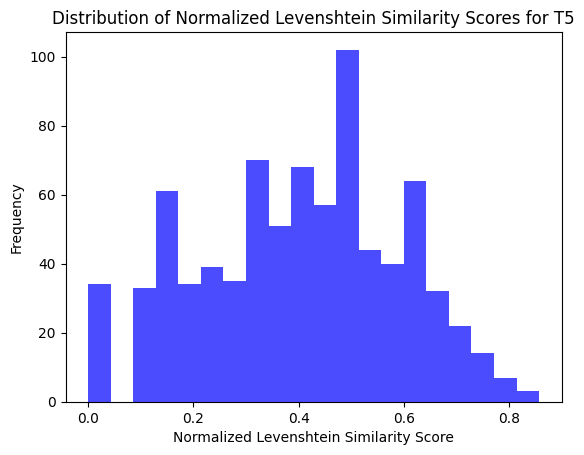

Testing Case with: learning rate 0.0005, epochs 20, alpha 0.7, num_beams 8, no_repeat_ngram_size 4


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


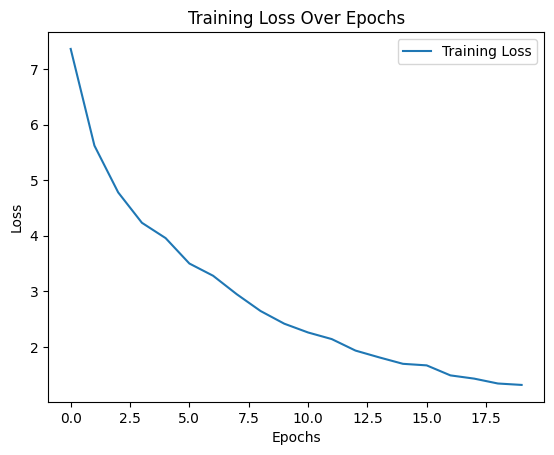

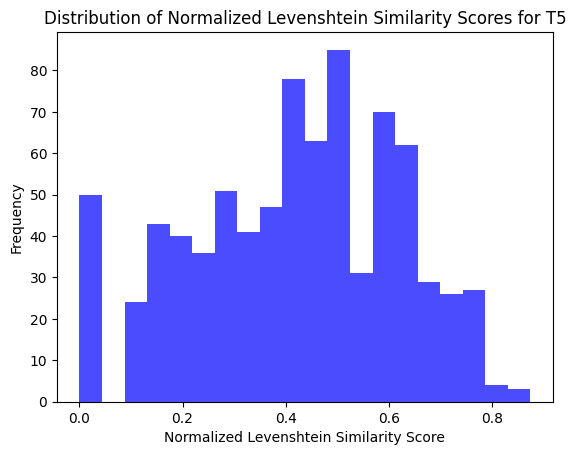

Scenario 4: Modified T5, With Masking
    MT5_lr  MT5_epochs  alpha  num_beams  no_repeat_ngram_size  Mean Score
0   0.0001          10    0.5          4                     2    0.393555
1   0.0001          10    0.5          4                     4    0.387954
2   0.0001          10    0.5          8                     2    0.402612
3   0.0001          10    0.5          8                     4    0.480479
4   0.0001          10    0.7          4                     2    0.396810
5   0.0001          10    0.7          4                     4    0.452748
6   0.0001          10    0.7          8                     2    0.391656
7   0.0001          10    0.7          8                     4    0.417318
8   0.0001          20    0.5          4                     2    0.355868
9   0.0001          20    0.5          4                     4    0.385809
10  0.0001          20    0.5          8                     2    0.357164
11  0.0001          20    0.5          8                     4

In [ ]:
# options
lr_values = [0.0001, 0.0005]
epoch_values = [10, 20]
alpha_values = [0.5, 0.7]
num_beams_input = [4, 8]
no_repeat_ngram_size_input = [2, 4]
custom_loss_input = 'yes'
use_masked_data_input = 'no'

# iterate through all options
T5M_2_results = []
for lr in lr_values:
    for epochs in epoch_values:
        for alpha in alpha_values:
            for num_beams in num_beams_input:
                for no_repeat_ngram_size in no_repeat_ngram_size_input:
                    print(f"Testing Case with: learning rate {lr}, epochs {epochs}, alpha {alpha}, num_beams {num_beams}, no_repeat_ngram_size {no_repeat_ngram_size}")
                    mean_score = T5_train_and_evaluate(lr, epochs, alpha, custom_loss_input, use_masked_data_input, num_beams, no_repeat_ngram_size)
                    T5M_2_results.append({
                        'MT5_lr': lr,
                        'MT5_epochs': epochs,
                        'alpha': alpha,
                        'num_beams': num_beams,
                        'no_repeat_ngram_size': no_repeat_ngram_size,
                        'Mean Score': mean_score
                    })

results_T5M_2 = pd.DataFrame(T5M_2_results)
print("Scenario 4: Modified T5, With Masking")
print(results_T5M_2)